########## Original Code ##################

In [ ]:
# HDI-v10 - AE-enabeld ==> Using MNIST  + HDS Metric added + Disentanglement Metrics : Beta-VAE, FactorVAE, MIG, TC_proxy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score # For discrete MI estimation
############################################################ Target Values
#Define the target correlations
target_correlations = [0.9, 0.7, 0.5, 0.3, 0.1]

# Define target dependence values (adjust as needed)
target_dependence = [0.85, 0.65, 0.45, 0.25, 0.15]  # Example values

# Under the Gaussian distribution, the correlation coefficient and mutual information have a one-to-one mapping:
def rho_to_mi(rho, dim):
    result = -dim / 2 * np.log(1 - rho ** 2)
    return result

def mi_to_rho(mi, dim):
    result = np.sqrt(1 - np.exp(-2 * mi / dim))
    return result

# Calculate target mutual information values from target correlations
target_MIs = []
for rho in target_correlations:
    mi = rho_to_mi(rho, dim=1)  # Assuming 1-dimensional features
    target_MIs.append(round(mi, 2))
############################################################# Dataset


# Define the transform
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

############################################################# CUDA Setup
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

######################################################################
# ############################################################# Losses
# Define the correlation loss
def correlation_loss(tensor, target_correlations):
    level_1 = tensor[0]  # Level 1
    # print('tensor shape = ', tensor.shape)
    loss = 0.0
    correlations = []
    for i, target_corr in enumerate(target_correlations):
        # print('i= ',i, 'target_corr= ',target_corr )
        level_i = tensor[i + 1]  # Other levels
        level_1_flat = level_1.flatten(start_dim=0, end_dim=1)
        level_i_flat = level_i.flatten(start_dim=0, end_dim=1)
        # print('level_1_flat  shape= ',level_1_flat.shape)
        # print('level_i_flat  shape= ',level_i_flat.shape)

        # Compute Pearson correlation
        cov = torch.mean((level_1_flat - level_1_flat.mean()) * (level_i_flat - level_i_flat.mean()))
        std_1 = level_1_flat.std()
        std_i = level_i_flat.std()
        corr = cov / (std_1 * std_i + 1e-8)
        correlations.append(corr.item())  # Store correlation
        loss += (corr - target_corr) ** 2

    return loss, correlations

# Define the independence loss
def independence_loss(tensor):
    loss = 0.0
    levels, batch_size, features = tensor.shape
    avg_correlations = []
    for level in tensor:
        level_corrs = []
        for i in range(features):
            for j in range(i + 1, features):
                col_i = level[:, i]
                col_j = level[:, j]
                cov = torch.mean((col_i - col_i.mean()) * (col_j - col_j.mean()))
                std_i = col_i.std()
                std_j = col_j.std()
                corr = cov / (std_i * std_j + 1e-8)
                level_corrs.append(corr.item())  # Store correlation
                loss += corr ** 2  # Penalize non-zero correlations
        avg_correlations.append(sum(level_corrs) / len(level_corrs))  # Average correlation for this level
    return loss, avg_correlations

# Define the mutual information loss
def mutual_information_loss(tensor, target_MIs):
    level_1 = tensor[0].detach().cpu().numpy()  # Level 1
    loss = 0.0
    mutual_infos = []
    lambda_reg = 0.01  # Regularization parameter

    for i, target_corr in enumerate(target_MIs):
        level_i = tensor[i + 1].detach().cpu().numpy()  # Other levels

        # Flatten the tensors for mutual information calculation
        level_1_flat = level_1.reshape(-1)
        level_i_flat = level_i.reshape(-1)

        # Compute mutual information using sklearn
        mi = mutual_info_regression(level_1_flat.reshape(-1, 1), level_i_flat, random_state=42)
        mi_value = mi[0] / np.log(2)  # Normalize MI to the range [0, 1]

        mutual_infos.append(mi_value)  # Store normalized mutual information
        weight = 1.0 if mi_value < target_corr else 0.5  # Dynamic weighting
        loss += weight * (mi_value - target_corr) ** 2  # Penalize deviation from target

    # Add regularization
    loss += lambda_reg * np.sum(np.square(mutual_infos))  # L2 regularization

    return loss, mutual_infos

# Define the distance correlation function
def distance_correlation(x, y):
    x = x - x.mean()
    y = y - y.mean()

    # Compute pairwise distances
    a = torch.cdist(x.unsqueeze(0), x.unsqueeze(0), p=2).squeeze()
    b = torch.cdist(y.unsqueeze(0), y.unsqueeze(0), p=2).squeeze()

    # Double centering
    A = a - a.mean(dim=0) - a.mean(dim=1).unsqueeze(1) + a.mean()
    B = b - b.mean(dim=0) - b.mean(dim=1).unsqueeze(1) + b.mean()

    # Compute distance covariance, variance, and correlation
    dcov = torch.sqrt((A * B).mean())
    dvar_x = torch.sqrt((A * A).mean())
    dvar_y = torch.sqrt((B * B).mean())

    return dcov / (torch.sqrt(dvar_x * dvar_y) + 1e-8)

# Define the adjacent level dependence loss
def adjacent_level_dependence_loss(tensor, target_dependence):
    levels, batch_size, features = tensor.shape
    loss = 0.0
    dependence_values = []

    for i in range(levels-1 ):
        # print('\n i= ',i)
        level_i = tensor[i].reshape(-1, features)
        level_next = tensor[i + 1].reshape(-1, features)

        dcorr = distance_correlation(level_i, level_next)
        dependence_values.append(dcorr.item())
        # print('dependence_values= ',dependence_values)

        # Compare to target dependence
        if i < len(target_dependence):  # Ensure we have a target value
            loss += (dcorr - target_dependence[i])**2
    return loss, dependence_values
########################################################################## Models
# Define the hierarchical bottleneck model
class HDI_model(nn.Module):
    def __init__(self, levels, features, dropout_rate=0.1, activation=nn.ReLU):
        """
        Enriched Correlation Model for Hierarchical Disentangled Information (HDI).

        Args:
            levels (int): Number of hierarchical levels.
            features (int): Number of features per level.
            dropout_rate (float): Dropout rate for regularization.
            activation (nn.Module): Activation function to use (default: ReLU).
        """
        super(HDI_model, self).__init__()
        self.levels = levels
        self.features = features
        self.activation = activation()

        # Define linear layers for each level (except the first one)
        self.linear_layers = nn.ModuleList([
            nn.Linear(features, features) for _ in range(levels - 1)
        ])

        # Define normalization layers for each level
        self.norm_layers = nn.ModuleList([
            nn.LayerNorm(features) for _ in range(levels - 1)
        ])

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, encoder_output):
        """
        Forward pass through the hierarchical model.
        Args:
            encoder_output (torch.Tensor): Input tensor from the encoder (shape: [batch_size, features]).
        Returns:
            torch.Tensor: Stacked tensor of hierarchical levels (shape: [levels, batch_size, features]).
        """
        levels = [encoder_output]  # First level is the encoder output
        for i, (layer, norm) in enumerate(zip(self.linear_layers, self.norm_layers)):
            # Linear transformation
            transformed = layer(levels[-1])
            # Add residual connection
            residual = transformed + levels[-1]
            # Apply normalization
            normalized = norm(residual)
            # Apply activation function
            activated = self.activation(normalized)
            # Apply dropout
            dropped_out = self.dropout(activated)
            # Append to levels
            levels.append(dropped_out)
        #print('mrh= ',torch.stack(levels).shape) # (levels, batch_size, BN_dim)
        # Stack levels into a tensor
        return torch.stack(levels)


class SimpleHDI(nn.Module):
    def __init__(self, levels, features):
        """
        Simple bottleneck that repeats the same level across all levels.
        Args:
            levels (int): Number of hierarchical levels.
            features (int): Number of features per level.
        """
        super(SimpleHDI, self).__init__()
        self.levels = levels
        self.features = features

    def forward(self, x):
        """
        Forward pass through the simple bottleneck.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, features).
        Returns:
            torch.Tensor: Bottleneck tensor of shape (levels, batch_size, features),
                          where all levels are identical.
        """
        # Repeat the input tensor across the levels dimension
        return x.unsqueeze(0).repeat(self.levels, 1, 1)



import torch
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder2(nn.Module):
    def __init__(self, input_dim, hidden_dim, BN_dim, levels):
        super(Autoencoder2, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], BN_dim)  # Output is (batch_size, BN_dim)
        )

        # Bottleneck (HDI layer)
        # self.bottleneck = SimpleHDI(levels, BN_dim)  # or HDI2(levels, BN_dim)
        self.bottleneck = HDI_model(levels, BN_dim)  # or HDI2(levels, BN_dim)

        # Attention mechanism to extract one (batch_size, BN_dim) from (levels, batch_size, BN_dim)
        self.attention = nn.Sequential(
            nn.Linear(BN_dim, 1),  # Compute attention score for each level
            nn.Softmax(dim=0)      # Normalize scores across levels
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(BN_dim, hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], input_dim),
            nn.Tanh()  # Output normalized to [-1, 1]
        )

    def forward(self, x, method="attention", fixed_level=0, manual_weights=None):
        """
        Forward pass with a flag to choose the method for extracting (batch_size, BN_dim).

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).
            method (str): Method to extract (batch_size, BN_dim) from (levels, batch_size, BN_dim).
                          Options: "attention", "fixed", "weighted".
            fixed_level (int): Index of the level to select if method="fixed".
            manual_weights (torch.Tensor): Tensor of shape (levels,) containing weights for levels if method="weighted".

        Returns:
            torch.Tensor: Reconstructed input of shape (batch_size, input_dim).
        """
        # Encode input
        z = self.encoder(x)  # Shape: (batch_size, BN_dim)

        # Pass through HDI bottleneck
        HDI_levels = self.bottleneck(z)  # Shape: (levels, batch_size, BN_dim)

        if method == "attention":
            # Compute attention scores
            attention_scores = self.attention(HDI_levels)  # Shape: (levels, batch_size, 1)
            attention_scores = attention_scores.squeeze(-1)  # Shape: (levels, batch_size)

            # Weighted sum of levels using attention scores
            attention_scores = attention_scores.unsqueeze(-1)  # Shape: (levels, batch_size, 1)
            weighted_output = (HDI_levels * attention_scores).sum(dim=0)  # Shape: (batch_size, BN_dim)

        elif method == "fixed":
            # Select a specific level (e.g., first or last)
            weighted_output = HDI_levels[fixed_level]  # Shape: (batch_size, BN_dim)

        elif method == "weighted":
            # Use manually provided weights to compute a weighted sum
            if manual_weights is None:
                raise ValueError("manual_weights must be provided when method='weighted'")
            if manual_weights.shape[0] != HDI_levels.shape[0]:
                raise ValueError("manual_weights must have the same length as the number of levels")

            # Normalize weights to sum to 1
            manual_weights = manual_weights / manual_weights.sum()  # Shape: (levels,)
            manual_weights = manual_weights.unsqueeze(-1).unsqueeze(-1)  # Shape: (levels, 1, 1)

            # Weighted sum of levels
            weighted_output = (HDI_levels * manual_weights).sum(dim=0)  # Shape: (batch_size, BN_dim)

        else:
            raise ValueError(f"Invalid method: {method}. Choose from 'attention', 'fixed', or 'weighted'.")

        # Decode the weighted output
        x_reconstructed = self.decoder(weighted_output)  # Shape: (batch_size, input_dim)
        return x_reconstructed, HDI_levels
############################################################################### Configuration
# Hyperparameters
input_dim=28*28
hidden_dim=[256, 128]
levels = 6
BN_dim = 5 # Bottleneck features dim
learning_rate = 1e-3
num_epochs = 20  # Reduced for demonstration

################################################################## Initialization
# Initialize model, loss, and optimizer



# model = Autoencoder(input_dim, hidden_dim, BN_dim).to(device)
model= Autoencoder2(input_dim, hidden_dim, BN_dim, levels).to(device)
criterion = nn.MSELoss()  # Mean Squared Error for reconstruction
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

############################################ Metric ##################

# Define normalization bounds for PSNR and SSIM
PSNR_min, PSNR_max = 0, 100  # Example values, adjust as needed
SSIM_min, SSIM_max = 0, 1     # Example values, adjust as needed

def compute_normalized_metric(independence_loss, corr_loss, adj_loss, reconstruction_loss, C=1, D=1, PSNR=None, SSIM=None):
    # Calculate Mean Hierarchical Loss
    mean_hierarchical_loss = (corr_loss + adj_loss) / 2

    # Normalize losses to [0, 1]
    normalized_independence_loss = 1 - independence_loss
    normalized_mean_hierarchical_loss = 1 - mean_hierarchical_loss
    normalized_reconstruction_loss = 1 - reconstruction_loss

    # Normalize PSNR or SSIM if provided
    normalized_PSRN = (PSNR - PSNR_min) / (PSNR_max - PSNR_min) if PSNR else 0
    normalized_SSIM = (SSIM - SSIM_min) / (SSIM_max - SSIM_min) if SSIM else 0

    # Compute the overall metric using Reconstruction Loss

    HDS = (normalized_independence_loss + C * normalized_mean_hierarchical_loss ) / (1 + C )
    HDSr = (normalized_independence_loss + C * normalized_mean_hierarchical_loss + D * normalized_reconstruction_loss) / (1 + C + D)

    # Compute the overall metric using PSNR
    metric_PSRN = (normalized_independence_loss + C * normalized_mean_hierarchical_loss + D * normalized_PSRN) / (1 + C + D)

    # Compute the overall metric using SSIM
    metric_SSIM = (normalized_independence_loss + C * normalized_mean_hierarchical_loss + D * normalized_SSIM) / (1 + C + D)

    HDSrc=0

    return HDS, HDSr,HDSrc # metric_PSRN, metric_SSIM


####
import torch

class HierarchicalMetric:
    def __init__(self, D=1, H=1, R=1, C=1):
        self.D = D
        self.H = H
        self.R = R
        self.C = C

    def compute_variability(self, HDI_levels):
        """
        Compute the variability from hierarchical disentangled levels.

        Args:
            HDI_levels (list of tensors): A list or tensor of bottleneck representations across M levels.

        Returns:
            float: The mean variance across levels.
        """
        variances = [torch.var(level, dim=0, unbiased=False).mean() for level in HDI_levels]
        mean_variability = torch.mean(torch.stack(variances))  # Mean variance across levels
        return mean_variability

    def compute_reconstruction_completeness(self, reconstruction_loss, R_max):
        """
        Compute completeness based on the normalized reconstruction loss.

        Args:
            reconstruction_loss (float): The reconstruction loss.
            R_max (float): The maximum possible reconstruction loss.

        Returns:
            float: Normalized completeness value.
        """
        if R_max > 0:
            return 1 - (reconstruction_loss / R_max)
        return 0

    def compute_normalized_metric(self, independence_loss, corr_loss, adj_loss,
                                   reconstruction_loss=None, HDI_levels=None, R_max=None):
        """
        Compute the normalized metric including various completeness measures.

        Args:
            independence_loss (float): The independence loss from the model.
            corr_loss (float): The correlation loss from the model.
            adj_loss (float): The adjacency loss from the model.
            reconstruction_loss (float, optional): The reconstruction loss from the model.
            HDI_levels (list of tensors, optional): The bottleneck representations.
            R_max (float, optional): Maximum possible reconstruction loss for completeness calculation.

        Returns:
            float: The overall computed metric.
        """

        # Mean Hierarchical Loss
        mean_hierarchical_loss = (corr_loss + adj_loss) / 2

        # Normalize losses to [0, 1]
        normalized_independence_loss = 1 - independence_loss
        normalized_mean_hierarchical_loss = 1 - mean_hierarchical_loss
        normalized_reconstruction_loss = 1 - reconstruction_loss if reconstruction_loss is not None else 0

        # Compute Completeness: either based on variability or reconstruction loss
        completeness_value = 0
        if HDI_levels is not None:
            # Option 1: Completeness based on variability
            variability = self.compute_variability(HDI_levels)
            completeness_value = variability.item()  # Mean variability as completeness
            # You could also incorporate other completeness methods based on your requirements:
            # completeness_value = self.compute_reconstruction_completeness(reconstruction_loss, R_max)

        # Compute the overall metric
        HDS   = (self.D * normalized_independence_loss + self.H * normalized_mean_hierarchical_loss ) / (self.D + self.H )
        HDSr  = (self.D * normalized_independence_loss + self.H * normalized_mean_hierarchical_loss + self.R * normalized_reconstruction_loss) / (self.D + self.H + self.R)
        HDSc  = (self.D * normalized_independence_loss + self.H * normalized_mean_hierarchical_loss + self.C * completeness_value) / (self.D + self.H + self.C)
        HDSrc = (self.D * normalized_independence_loss + self.H * normalized_mean_hierarchical_loss + self.R * normalized_reconstruction_loss + self.C * completeness_value) / (self.D + self.H + self.R + self.C)


        return HDS, HDSr, HDSc, HDSrc
######################################################################
def estimate_discrete_mi(x, y):
    """
    Estimates the discrete mutual information between two discrete variables.

    Args:
        x (np.ndarray): First discrete variable (must be 1D array).
        y (np.ndarray): Second discrete variable (must be 1D array).

    Returns:
        float: Estimated mutual information score.
    """
    # Ensure inputs are 1D arrays
    return mutual_info_score(x.flatten(), y.flatten())
def beta_vae_metric(latent_codes, ground_truth_labels): # Removed latent_dim arg, derived from latent_codes
    latent_dim = latent_codes.shape[1]
    scores = []
    for i in range(latent_dim):
        X = latent_codes[:, i].reshape(-1, 1)
        #print('X shape= ',X.shape)
        #print('X len= ',len(X))
        y = ground_truth_labels
        #print('Y shape= ',y.shape)
        #print('len(np.unique(y))= ',len(np.unique(y)))
        # Ensure enough samples for split and unique classes
        if len(X) < 100 or len(np.unique(y)) < 2: # Added a minimum sample check
             # print(f"Skipping latent dim {i} due to insufficient data or classes.")
             scores.append(0.0)
            #  print('@')
             continue

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y if len(np.unique(y)) > 1 else None)

        # Check again after split
        if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
             # print(f"Skipping latent dim {i} due to insufficient classes after split.")
             scores.append(0.0)
            #  print('@@')
             continue

        try:
            classifier = LogisticRegression(solver='liblinear', random_state=42) # Removed multi_class='auto'
            classifier.fit(X_train, y_train)
            score = classifier.score(X_test, y_test)
            scores.append(score)
            #print('MRH score= ',score)

        except Exception as e:
            # print(f"Warning: Could not train classifier for latent dim {i}: {e}")
            scores.append(0.0)
            # print('@@@')
    # Handle case where no scores were added
    return np.mean(scores) if scores else 0.0


def factor_vae_metric(latent_codes, ground_truth_labels): # Removed latent_dim arg
    latent_dim = latent_codes.shape[1]
    num_bins = 10
    # Ensure enough samples for binning
    if len(latent_codes) == 0:
        return 0.0
    # Calculate bins based on the range of the entire latent space
    global_min = latent_codes.min()
    global_max = latent_codes.max()
    if global_max == global_min: # Avoid division by zero or constant values
         binned_latent_codes = np.zeros_like(latent_codes, dtype=int)
    else:
         bins = np.linspace(global_min, global_max, num_bins + 1) # +1 for edges
         # Ensure all values fall within bins, clip extreme values
         binned_latent_codes = np.digitize(latent_codes, bins=bins)
         # Adjust bin indices to be 0-based
         binned_latent_codes[binned_latent_codes == num_bins + 1] = num_bins # Clip max values
         binned_latent_codes = binned_latent_codes - 1 # Make 0-indexed
         binned_latent_codes[binned_latent_codes < 0] = 0 # Clip min values


    mi_scores = []
    for i in range(latent_dim):
        # Check if there's enough variation in the binned dimension and labels
        if len(np.unique(binned_latent_codes[:, i])) > 1 and len(np.unique(ground_truth_labels)) > 1:
            try:
                 mi = estimate_discrete_mi(binned_latent_codes[:, i], ground_truth_labels)
                 mi_scores.append(mi)
            except ValueError as e:
                 # mutual_info_score can raise ValueError for insufficient unique labels
                 # print(f"Warning: Could not estimate MI for latent dim {i}: {e}")
                 mi_scores.append(0.0)
        else:
            mi_scores.append(0.0) # No variation means no mutual information

    return np.max(mi_scores) if mi_scores else 0.0 # Simplified for MNIST single factor

def mutual_information_gap(latent_codes, ground_truth_labels): # Removed latent_dim arg
    latent_dim = latent_codes.shape[1]
    num_bins = 10
    if len(latent_codes) == 0:
        return 0.0
    global_min = latent_codes.min()
    global_max = latent_codes.max()
    if global_max == global_min:
         binned_latent_codes = np.zeros_like(latent_codes, dtype=int)
    else:
         bins = np.linspace(global_min, global_max, num_bins + 1)
         binned_latent_codes = np.digitize(latent_codes, bins=bins)
         binned_latent_codes[binned_latent_codes == num_bins + 1] = num_bins
         binned_latent_codes = binned_latent_codes - 1
         binned_latent_codes[binned_latent_codes < 0] = 0

    mi_scores_per_latent_dim = []
    for i in range(latent_dim):
        if len(np.unique(binned_latent_codes[:, i])) > 1 and len(np.unique(ground_truth_labels)) > 1:
             try:
                  mi = estimate_discrete_mi(binned_latent_codes[:, i], ground_truth_labels)
                  mi_scores_per_latent_dim.append(mi)
             except ValueError:
                  mi_scores_per_latent_dim.append(0.0)
        else:
             mi_scores_per_latent_dim.append(0.0)

    sorted_mi = sorted(mi_scores_per_latent_dim, reverse=True)

    # Ensure there are at least two MI scores to calculate a gap
    if len(sorted_mi) >= 2:
        mig_for_factor = sorted_mi[0] - sorted_mi[1]
    else:
        mig_for_factor = 0 # Cannot calculate gap with less than 2 dimensions

    return mig_for_factor


def total_correlation_proxy(latent_codes):
    if latent_codes.shape[1] < 2 or len(latent_codes) < 2: # Need at least 2 samples for correlation
         return 0.0
    try:
         correlation_matrix = np.corrcoef(latent_codes.T)
         # Check if correlation matrix is valid (no NaNs or Infs)
         if not np.all(np.isfinite(correlation_matrix)):
              print("Warning: Non-finite values in correlation matrix. Returning 0.0 for TC proxy.")
              return 0.0

         off_diagonal_abs_sum = np.sum(np.abs(correlation_matrix - np.eye(correlation_matrix.shape[0])))
         num_off_diagonal = correlation_matrix.shape[0] * (correlation_matrix.shape[0] - 1)

         if num_off_diagonal > 0:
             return off_diagonal_abs_sum / num_off_diagonal
         else:
             return 0.0
    except Exception as e:
         print(f"Error calculating TC proxy: {e}")
         return 0.0




#######################################################################
# Track metrics for plotting
correlation_history = []  # To track correlations between levels
independence_history = []  # To track average independence correlations
mutual_information_history = []  # To track mutual information between levels
adjacent_dependence_history = []  # To track adjacent level dependence

# Initialize lists to track losses
corr_loss_history = []  # To track correlation loss
indep_loss_history = []  # To track independence loss
mi_loss_history = []
adj_loss_history=[]
total_loss_history = []  # To track total loss

HDS_history = []
HDSr_history = []
HDSc_history = []
HDSrc_history = []
#
beta_vae_scores_history=[]
factor_vae_scores_history=[]
mig_scores_history=[]
tc_proxy_scores_history=[]

model.train()

# Create an instance of HierarchicalMetric
metric_calculator = HierarchicalMetric(D=1, H=1, R=1, C=1)
previous_beta_vae_score=0
# Training the autoencoder
for epoch in range(num_epochs):
    # train_loss = train(model, train_loader, criterion, optimizer, device)

    train_loss = 0
    for images, targets in train_loader:
        images = images.to(device)
        images = images.view(images.size(0), -1)  # Flatten images

        ############################################### Forward pass
        # MRH: simple
        # output = model(images)

        # MRH: Attention
        output, HDI_levels = model(images, method="attention")
        #print('\nHDI_levels= ',HDI_levels)

        # print('HDI_levels type= ', type(HDI_levels))
        # print('HDI_levels shape= ', HDI_levels.shape)

        # raise Exception("Mohammad Reza Hasanabadi")

        # MRH: Fixed
        #output = model(images, method="fixed", fixed_level=3)  # Select the first level
        #print('\nimages shape= ',images.shape) # torch.Size([256, 784])
        #print('output shape= ',output.shape) # torch.Size([256, 784])

        # MRH: Weighted
        # manual_weights = torch.tensor([0.1, 0.2, 0.3, 0.4]).to(device)  # Example weights for 4 levels
        # output = model(images, method="weighted", manual_weights=manual_weights)

        ############################################# Compute the losses
        reconstruction_loss = criterion(output, images)
        corr_loss, correlations = correlation_loss(HDI_levels, target_correlations)
        indep_loss, avg_independence_corrs = independence_loss(HDI_levels)
        # mi_loss, mutual_infos = mutual_information_loss(HDI_levels target_MIs)
        adj_loss, dependence_values = adjacent_level_dependence_loss(HDI_levels, target_dependence)

        total_loss = reconstruction_loss + corr_loss + 0.1 * indep_loss  + 0.1 * adj_loss

        # Backward pass and optimization
        # total_loss.backward()




        # Backward pass
        optimizer.zero_grad()
        # loss.backward()
        total_loss.backward()
        optimizer.step()


        # Track Parameters
        correlation_history.append(correlations)
        independence_history.append(avg_independence_corrs)
        # mutual_information_history.append(mutual_infos)
        adjacent_dependence_history.append(dependence_values)


        # Track losses
        corr_loss_history.append(corr_loss.item())
        indep_loss_history.append(indep_loss.item())
        # mi_loss_history.append(mi_loss.item())
        adj_loss_history.append(adj_loss.item())
        total_loss_history.append(total_loss.item())

        # train_loss += loss.item()
        train_loss += total_loss.item()



        # Calculate metrics
        HDS, HDSr, HDSc, HDSrc = metric_calculator.compute_normalized_metric(
            indep_loss.item(),
            corr_loss.item(),
            adj_loss.item(),
            reconstruction_loss.item(),
            HDI_levels=HDI_levels
        )


        ##
        HDS_history.append(HDS)
        HDSr_history.append(HDSr)
        HDSc_history.append(HDSc)
        HDSrc_history.append(HDSrc)


        ###

        #############################################


                                        # #model.eval() # Set model to evaluation mode
        # latent_codes = []
        # labels = []
                                        # print("Extracting initial encoder output (z) from test set for metric calculation...")
                                        # with torch.no_grad():
                                        #     for images, targets in dataloader:
                                        #         images = images.to(device)
                                                # Get the initial encoder output 'z' directly from the encoder
                                                # We DO NOT use the full model.forward() here for metric extraction,
                                                # because the metrics apply to the *input* of the HDI layer.
        z = model.encoder(images)
        latent_code = z.detach().cpu().numpy()
        labels = targets.cpu().numpy()
                                        # return np.concatenate(latent_codes, axis=0), np.concatenate(labels, axis=0)
        ############################################
        latent_codes = HDI_levels[0]  # Use the last HDI level or average/concatenate as needed
        # print('z shape=  ', z.shape)
        # print('latent_codes shape = ',latent_codes.shape )


        #
        latent_dim = latent_codes.shape[1]
        scores = []
        # for i in range(latent_dim):
        #     X = latent_codes[:, i].reshape(-1, 1)
        #     print('X shape= ',X.shape)
        #     print('X len= ',len(X))
        #     print('np.unique(ground_truth_labels= ',np.unique(labels))

        # raise Exception("Sorry, Mohammad Reza Hasanabadi")
        # Calculate disentanglement metrics
        beta_vae_score = beta_vae_metric(latent_code, labels)
        factor_vae_score = factor_vae_metric(latent_code, labels)
        mig_score = mutual_information_gap(latent_code, labels)
        tc_proxy_score = total_correlation_proxy(latent_code)
        #print('beta_vae_score= ',beta_vae_score)

        #### MRH: Consideration for beta- VAE to avoid being zero at lat batch less than 256
        if beta_vae_score == 0.0 and previous_beta_vae_score != 0.0:
            beta_vae_score = previous_beta_vae_score
        previous_beta_vae_score = beta_vae_score # Update the previous score
        ####

        # Store the metrics collected in this epoch
        beta_vae_scores_history.append(beta_vae_score)
        factor_vae_scores_history.append(factor_vae_score)
        mig_scores_history.append(mig_score)
        tc_proxy_scores_history.append(tc_proxy_score)

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Reconstruction Loss: {reconstruction_loss.item():.4f}, "
          f"Correlation Loss: {corr_loss.item():.4f}, Independence Loss: {indep_loss:.4f}, "
          f"Adjacent Dependence Loss: {adj_loss:.4f}, "
          f"Total Loss: {total_loss.item():.4f}, "
          f"HDS: {HDS:.4f}, HDSr: {HDSr:.4f}, HDSc: {HDSc:.4f}, HDSrc: {HDSrc:.4f}, "
          f"Beta-VAE: {beta_vae_score:.4f}, Factor VAE: {factor_vae_score:.4f}, "
          f"MIG: {mig_score:.4f}, TC Proxy: {tc_proxy_score:.4f}"
          )
    #raise Exception("Sorry, Mohammad Reza Hasanabadi")
    # print(f"Epoch [{epoch + 1}/{num_epochs}], "
    #       f"Reconstruction Loss: {reconstruction_loss.item():.4f}, "
    #       f"Correlation Loss: {corr_loss.item():.4f}, Independence Loss: {indep_loss:.4f}, "
    #       f"Adjacent Dependence Loss: {adj_loss:.4f}, "
    #       f"Total Loss: {total_loss.item():.4f},"
    #       f"HDS: {HDS:.4f}, "
    #       f"HDSr: {HDSr:.4f}, "
    #       f"HDSc: {HDSc:.4f},"
    #       f"HDSrc: {HDSrc:.4f}"
    #       )


##########
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        images = images.view(images.size(0), -1)  # Flatten images
        outputs,_ = model(images)
images = images.view(-1, 28, 28).cpu().numpy()
outputs = outputs.view(-1, 28, 28).cpu().numpy()

# Plot original and reconstructed images
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    plt.subplot(2, n, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed images
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(outputs[i], cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()
            # return images, outputs  # Return a batch for visualization

####################################################
fig, axs = plt.subplots(1, 4, figsize=(18, 6))
losses = [
    (corr_loss_history, "Correlation Loss", "blue"),
    (indep_loss_history, "Independence Loss", "orange"),
    (adj_loss_history, "Adjacent Dependence Loss", "magenta"),
    (total_loss_history, "Total Loss", "green"),
]

for i, (loss, title, color) in enumerate(losses):
    axs[i].plot(loss, color=color, linewidth=2)
    axs[i].set_title(title)
    axs[i].set_xlabel("Epochs")
    axs[i].set_ylabel("Loss")
    axs[i].grid()

plt.tight_layout()
plt.show()

# Convert tracked metrics to tensors for easier plotting
correlation_history = torch.tensor(correlation_history)
independence_history = torch.tensor(independence_history)
# mutual_information_history = torch.tensor(mutual_information_history)
adjacent_dependence_history = torch.tensor(adjacent_dependence_history)

# Plot Correlations Between Levels
plt.figure(figsize=(12, 6))
colors = ['r', 'g', 'b', 'orange', 'purple']
for i, color in enumerate(colors):
    plt.plot(correlation_history[:, i], label=f"Level {i + 2} (Target: {target_correlations[i]})", color=color, linewidth=2)
    plt.axhline(y=target_correlations[i], color=color, linestyle='--', linewidth=1.5)  # Target line
plt.title("Correlation Between Level 1 and Other Levels")
plt.xlabel("Epochs")
plt.ylabel("Correlation")
plt.legend()
plt.grid()
plt.show()

# Plot Average Independence Correlations Within Levels
plt.figure(figsize=(12, 6))
for i in range(levels):
    plt.plot(independence_history[:, i], label=f"Level {i + 1}", linewidth=2)
plt.title("Average Independence Correlations (Within Levels)")
plt.xlabel("Epochs")
plt.ylabel("Average Correlation")
plt.legend()
plt.grid()
plt.show()

# Plot Mutual Information Between Levels
# plt.figure(figsize=(12, 6))
# for i, color in enumerate(colors):
#     plt.plot(mutual_information_history[:, i], label=f"Level {i + 2} (Target: {target_MIs[i]})", color=color, linewidth=2)
#     plt.axhline(y=target_MIs[i], color=color, linestyle='--', linewidth=1.5)  # Target line
# plt.title("Mutual Information Between Level 1 and Other Levels")
# plt.xlabel("Epochs")
# plt.ylabel("MI")
# plt.legend()
# plt.grid()
# plt.show()

# Plot Dependence Between Adjacent Levels
plt.figure(figsize=(12, 6))
for i, color in enumerate(colors[:-1]):  # Only `levels - 1` adjacent levels
    dependence_by_level = [dependence[i] for dependence in adjacent_dependence_history]
    plt.plot(dependence_by_level, label=f"Level {i + 1} vs Level {i + 2}", color=color, linewidth=2)
    plt.axhline(y=target_dependence[i], color=color, linestyle='--', linewidth=1.5)  # Target line
plt.title("Dependence Between Adjacent Levels")
plt.xlabel("Epochs")
plt.ylabel("Dependence (Distance Correlation)")
plt.legend()
plt.grid()
plt.show()

#################################################### Metric
fig, axs = plt.subplots(1, 4, figsize=(18, 6))
metrics = [
    (HDS_history, "HDS_history", "blue"),
    (HDSr_history, "HDSr_history", "orange"),
    (HDSc_history, "HDSc_history", "magenta"),
    (HDSrc_history, "HDSrc_history", "green"),
]

for i, (metric, title, color) in enumerate(metrics):
    axs[i].plot(metric, color=color, linewidth=2)
    axs[i].set_title(title)
    axs[i].set_xlabel("Epochs")
    axs[i].set_ylabel("Loss")
    axs[i].grid()

plt.tight_layout()
plt.show()
#################################################################
fig, axs = plt.subplots(1, 4, figsize=(18, 6))
metrics = [
    (beta_vae_scores_history, "beta_vae_scores_history", "blue"),
    (factor_vae_scores_history, "factor_vae_scores_history", "orange"),
    (mig_scores_history, "mig_scores_history", "magenta"),
    (tc_proxy_scores_history, "tc_proxy_scores_history", "green"),
]

for i, (metric, title, color) in enumerate(metrics):
    axs[i].plot(metric, color=color, linewidth=2)
    axs[i].set_title(title)
    axs[i].set_xlabel("Epochs")
    axs[i].set_ylabel("Loss")
    axs[i].grid()

plt.tight_layout()
plt.show()


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.95MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.98MB/s]


Using device: cuda
Epoch [1/20], Reconstruction Loss: 0.2437, Correlation Loss: 0.0134, Independence Loss: 1.0739, Adjacent Dependence Loss: 0.5036, Total Loss: 0.4149, HDS: 0.3338, HDSr: 0.4746, HDSc: 0.2678, HDSrc: 0.3899, Beta-VAE: 0.2231, Factor VAE: 0.6605, MIG: 0.4502, TC Proxy: 0.0959
Epoch [2/20], Reconstruction Loss: 0.1878, Correlation Loss: 0.0091, Independence Loss: 1.0211, Adjacent Dependence Loss: 0.4172, Total Loss: 0.3408, HDS: 0.3829, HDSr: 0.5260, HDSc: 0.3261, HDSrc: 0.4476, Beta-VAE: 0.1962, Factor VAE: 0.6410, MIG: 0.3175, TC Proxy: 0.0786


KeyboardInterrupt: 

In [ ]:
############################

**Adding Comparison Models**

In [ ]:
################
################
################

In [ ]:
### Models ###
# Fixed BetaVAE forward method
class BetaVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, BN_dim):
        super(BetaVAE, self).__init__()
        self.BN_dim = BN_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], hidden_dim[1]),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim[1], BN_dim)
        self.fc_logvar = nn.Linear(hidden_dim[1], BN_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(BN_dim, hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], input_dim),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        h = self.encoder(x)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)

        # Decode
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z.unsqueeze(0), mu, logvar  # Return 4 values

# Fixed FactorVAE forward method
class FactorVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, BN_dim):
        super(FactorVAE, self).__init__()
        self.BN_dim = BN_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], hidden_dim[1]),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim[1], BN_dim)
        self.fc_logvar = nn.Linear(hidden_dim[1], BN_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(BN_dim, hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], input_dim),
            nn.Tanh()
        )

        # Discriminator for FactorVAE
        self.discriminator = nn.Sequential(
            nn.Linear(BN_dim, hidden_dim[1]),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim[1], hidden_dim[0]),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim[0], 2),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        h = self.encoder(x)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)

        # Decode
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z.unsqueeze(0), mu, logvar  # Return 4 values

# Fixed HierarchicalVAE forward method
class HierarchicalVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, BN_dim, levels):
        super(HierarchicalVAE, self).__init__()
        self.levels = levels
        self.BN_dim = BN_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], BN_dim * 2)  # mu and logvar for each level
        )

        # Hierarchical latent structure
        self.hierarchical_mapping = nn.ModuleList([
            nn.Linear(BN_dim, BN_dim) for _ in range(levels - 1)
        ])

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(BN_dim, hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], input_dim),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode to get parameters for all levels
        h = self.encoder(x)
        mu_logvar = h.view(-1, 2, self.BN_dim)
        mu, logvar = mu_logvar[:, 0], mu_logvar[:, 1]

        # Sample from first level
        z0 = self.reparameterize(mu, logvar)
        hierarchical_z = [z0.unsqueeze(0)]

        # Generate hierarchical levels
        current_z = z0
        for mapping in self.hierarchical_mapping:
            current_z = mapping(current_z)
            hierarchical_z.append(current_z.unsqueeze(0))

        # Stack all levels
        z_hierarchical = torch.cat(hierarchical_z, dim=0)

        # Decode from the last level
        x_reconstructed = self.decoder(z_hierarchical[-1])

        return x_reconstructed, z_hierarchical, mu, logvar  # Return 4 values

# Fixed VanillaAE forward method to return consistent number of outputs
class VanillaAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, BN_dim):
        super(VanillaAutoencoder, self).__init__()
        # Encoder (same as your Autoencoder2)
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], BN_dim)
        )

        # No bottleneck - direct connection
        self.bottleneck = nn.Identity()  # Just pass through

        # Decoder (same as your Autoencoder2)
        self.decoder = nn.Sequential(
            nn.Linear(BN_dim, hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], input_dim),
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        z_bottleneck = self.bottleneck(z)
        x_reconstructed = self.decoder(z_bottleneck)
        return x_reconstructed, z.unsqueeze(0), None, None  # Return 4 values with None for mu, logvar

# Fixed HDI Model forward method
class HDI_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, BN_dim, levels):
        super(HDI_Model, self).__init__()
        # Your original Autoencoder2 with HDI bottleneck
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], BN_dim)
        )

        # HDI Bottleneck (your core contribution)
        self.bottleneck = HDI_model(levels, BN_dim)

        self.attention = nn.Sequential(
            nn.Linear(BN_dim, 1),
            nn.Softmax(dim=0)
        )

        self.decoder = nn.Sequential(
            nn.Linear(BN_dim, hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], input_dim),
            nn.Tanh()
        )

    def forward(self, x, method="attention"):
        z = self.encoder(x)
        HDI_levels = self.bottleneck(z)

        if method == "attention":
            attention_scores = self.attention(HDI_levels).squeeze(-1)
            attention_scores = attention_scores.unsqueeze(-1)
            weighted_output = (HDI_levels * attention_scores).sum(dim=0)
        else:
            weighted_output = HDI_levels[0]  # Default to first level

        x_reconstructed = self.decoder(weighted_output)
        return x_reconstructed, HDI_levels, None, None  # Return 4 values with None for mu, logvar

In [ ]:
def vanilla_loss(reconstruction, original, model=None):
    return nn.MSELoss()(reconstruction, original), 0, 0, 0


# Beta-VAE Loss
def beta_vae_loss(reconstruction, original, mu, logvar, beta=4.0):
    reconstruction_loss = nn.MSELoss()(reconstruction, original)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss /= original.size(0) * 28 * 28  # Normalize by batch size and dimensions

    total_loss = reconstruction_loss + beta * kl_loss
    return total_loss, reconstruction_loss, kl_loss


# FactorVAE Loss
def factor_vae_loss(reconstruction, original, mu, logvar, z, discriminator, gamma=6.0):
    batch_size = original.size(0)

    # Reconstruction loss
    reconstruction_loss = nn.MSELoss()(reconstruction, original)

    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss /= batch_size * 28 * 28

    # Total Correlation loss
    # Permute the latent representation
    z_permuted = torch.zeros_like(z)
    for i in range(z.size(1)):  # For each latent dimension
        z_permuted[:, i] = z[torch.randperm(batch_size), i]

    # Discriminator loss
    d_z = discriminator(z)
    d_z_permuted = discriminator(z_permuted)

    # Use binary cross entropy with logits
    d_tc_loss = 0.5 * (nn.BCEWithLogitsLoss()(d_z, torch.ones_like(d_z)) +
                       nn.BCEWithLogitsLoss()(d_z_permuted, torch.zeros_like(d_z_permuted)))

    # Total loss
    total_loss = reconstruction_loss + kl_loss + gamma * d_tc_loss

    return total_loss, reconstruction_loss, kl_loss, d_tc_loss


# Hierarchical VAE Loss
def hierarchical_vae_loss(reconstruction, original, mu, logvar, beta=4.0):
    reconstruction_loss = nn.MSELoss()(reconstruction, original)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss /= original.size(0) * 28 * 28

    total_loss = reconstruction_loss + beta * kl_loss
    return total_loss, reconstruction_loss, kl_loss


# HDI Loss (your original loss functions)
def hdi_loss(reconstruction, original, HDI_levels, target_correlations, target_dependence):
    reconstruction_loss = nn.MSELoss()(reconstruction, original)
    corr_loss, correlations = correlation_loss(HDI_levels, target_correlations)
    indep_loss, independence_corrs = independence_loss(HDI_levels)
    adj_loss, dependence_values = adjacent_level_dependence_loss(HDI_levels, target_dependence)

    total_loss = (reconstruction_loss + corr_loss +
                  0.1 * indep_loss + 0.1 * adj_loss)

    return total_loss, reconstruction_loss, corr_loss, indep_loss, adj_loss

Using device: cuda

Training VanillaAE
Epoch 1/20, Train Loss: 0.2155, Val Loss: 0.1467, Beta-VAE: 0.2280
Epoch 6/20, Train Loss: 0.1068, Val Loss: 0.1052, Beta-VAE: 0.2480
Epoch 11/20, Train Loss: 0.0981, Val Loss: 0.0981, Beta-VAE: 0.2479
Epoch 16/20, Train Loss: 0.0932, Val Loss: 0.0939, Beta-VAE: 0.2569
VanillaAE training completed in 306.41 seconds

Training BetaVAE
Epoch 1/20, Train Loss: 0.2750, Val Loss: 0.2108, Beta-VAE: 0.1896
Epoch 6/20, Train Loss: 0.1703, Val Loss: 0.1320, Beta-VAE: 0.2166
Epoch 11/20, Train Loss: 0.1631, Val Loss: 0.1232, Beta-VAE: 0.2157
Epoch 16/20, Train Loss: 0.1595, Val Loss: 0.1180, Beta-VAE: 0.2165
BetaVAE training completed in 308.59 seconds

Training FactorVAE
Epoch 1/20, Train Loss: 1.3435, Val Loss: 0.2404, Beta-VAE: 0.2797
Epoch 6/20, Train Loss: 0.2528, Val Loss: 0.2057, Beta-VAE: 0.2751
Epoch 11/20, Train Loss: 0.2169, Val Loss: 0.1708, Beta-VAE: 0.2930
Epoch 16/20, Train Loss: 0.2004, Val Loss: 0.1540, Beta-VAE: 0.2729
FactorVAE training co

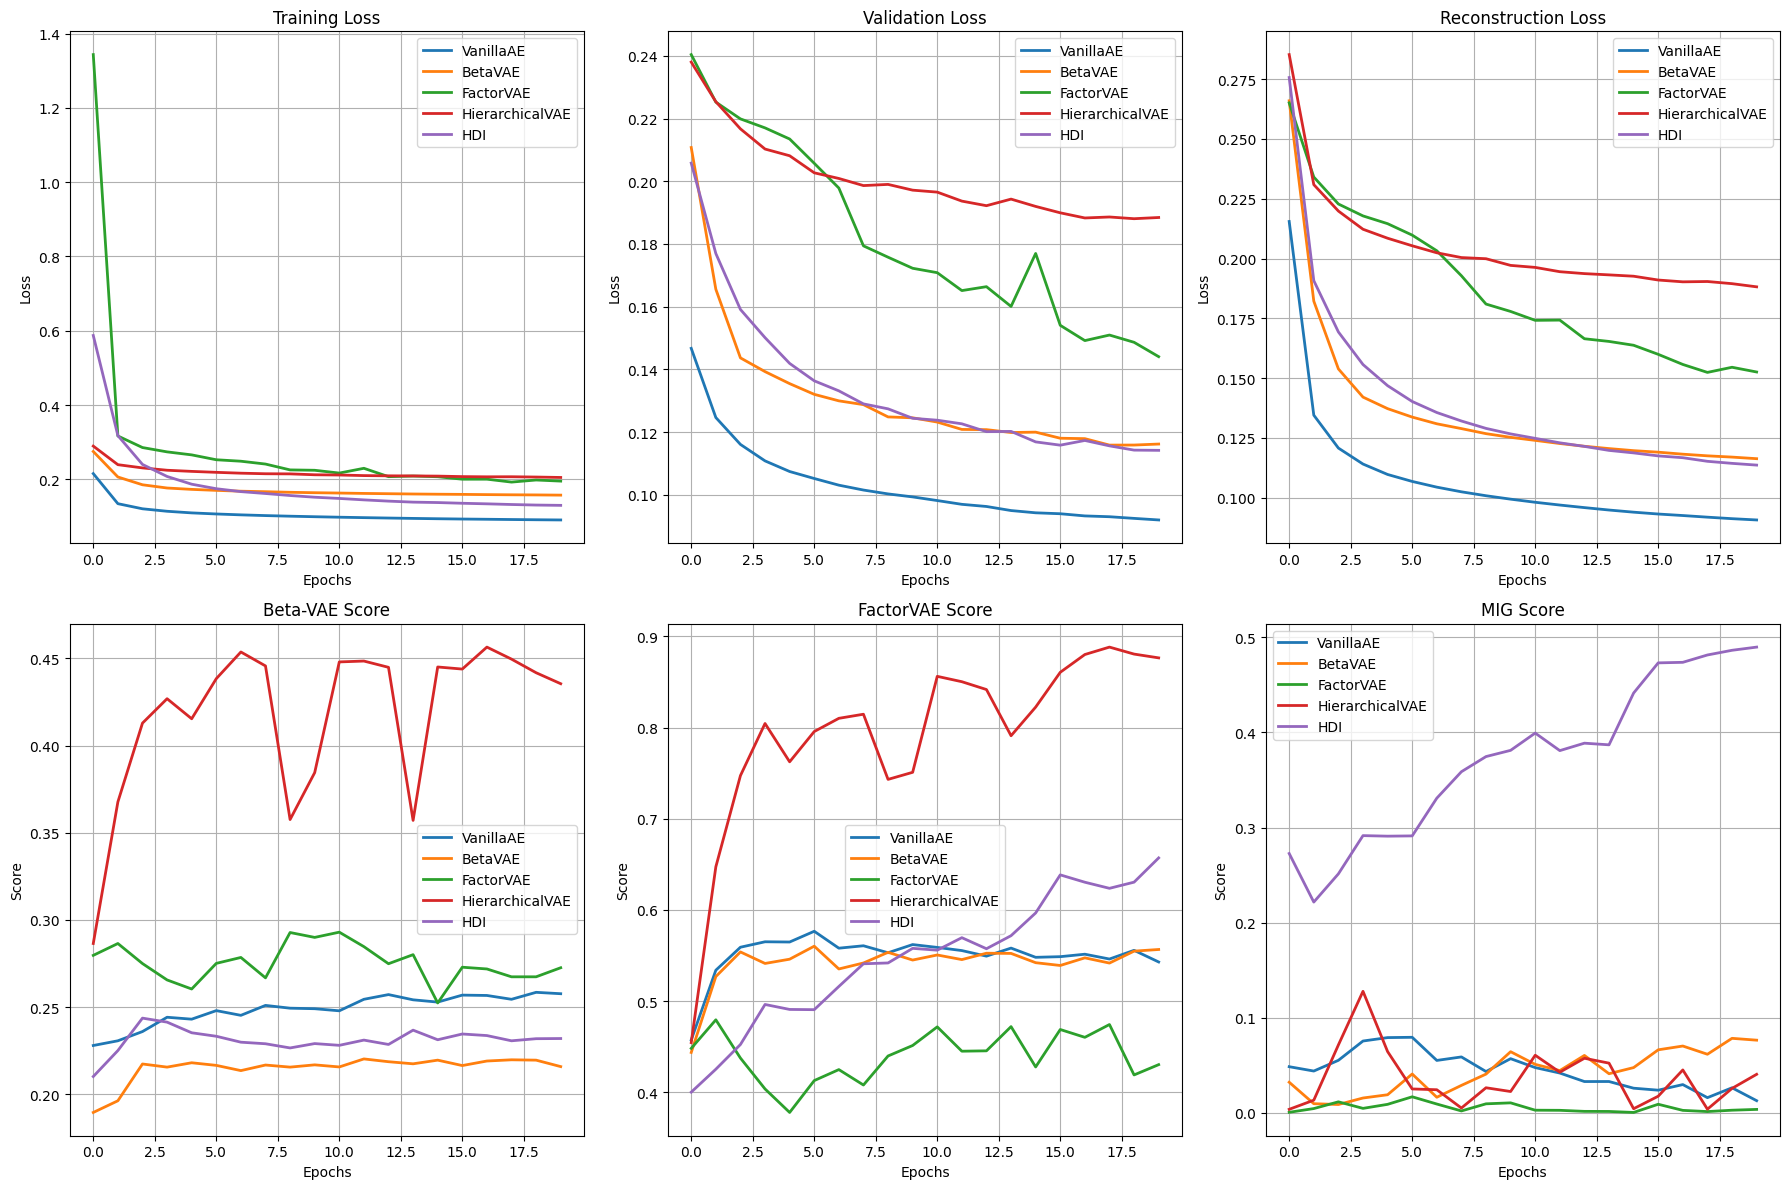

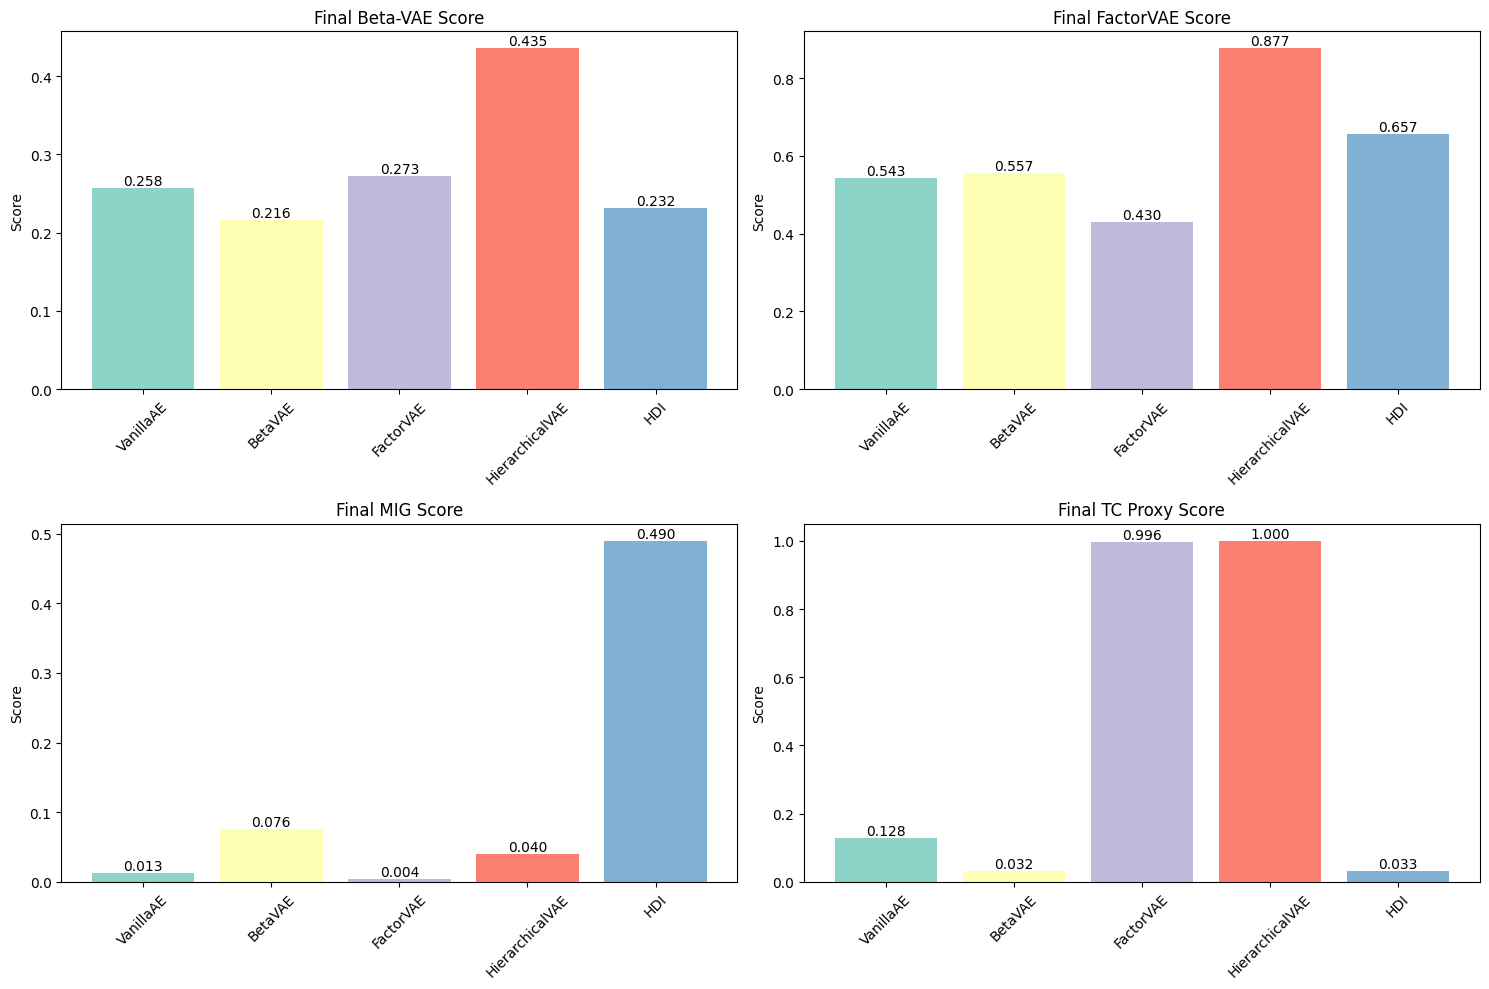

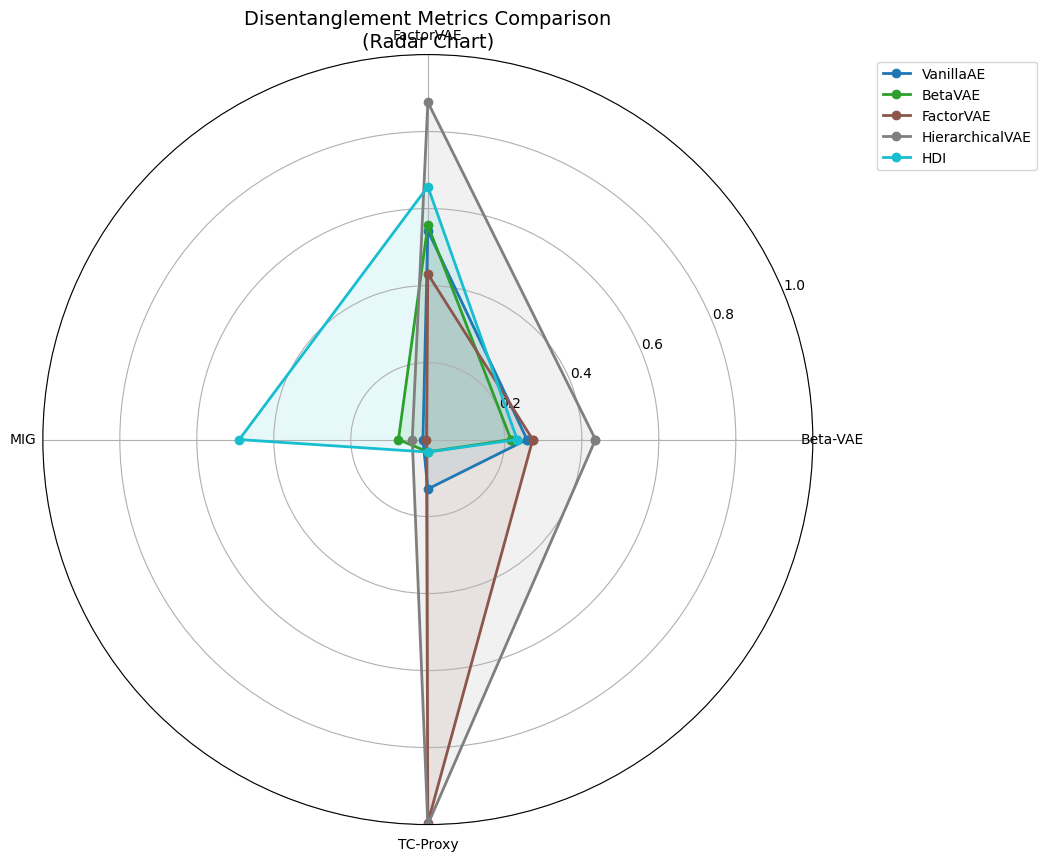

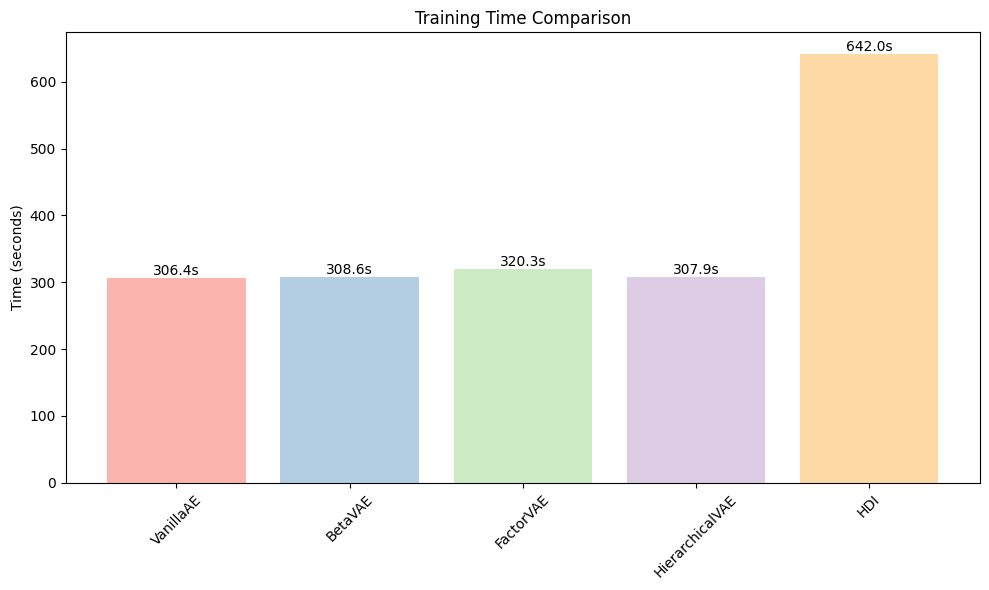


COMPREHENSIVE MODEL COMPARISON RESULTS
Model           Train Time   Beta-VAE    FactorVAE   MIG         TC-Proxy    
--------------------------------------------------------------------------------
VanillaAE       306.4s       0.2577      0.5429      0.0127      0.1284      
BetaVAE         308.6s       0.2159      0.5566      0.0764      0.0320      
FactorVAE       320.3s       0.2726      0.4302      0.0035      0.9955      
HierarchicalVAE 307.9s       0.4355      0.8765      0.0404      0.9999      
HDI             642.0s       0.2320      0.6570      0.4898      0.0325      


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

class ModelComparator:
    def __init__(self, config, device):
        self.config = config
        self.device = device
        self.models = {}
        self.histories = {}
        self.training_times = {}

    def initialize_models(self):
        """Initialize all models for comparison"""
        self.models = {
            'VanillaAE': VanillaAutoencoder(
                self.config.input_dim,
                self.config.hidden_dim,
                self.config.BN_dim
            ).to(self.device),

            'BetaVAE': BetaVAE(
                self.config.input_dim,
                self.config.hidden_dim,
                self.config.BN_dim
            ).to(self.device),

            'FactorVAE': FactorVAE(
                self.config.input_dim,
                self.config.hidden_dim,
                self.config.BN_dim
            ).to(self.device),

            'HierarchicalVAE': HierarchicalVAE(
                self.config.input_dim,
                self.config.hidden_dim,
                self.config.BN_dim,
                self.config.levels
            ).to(self.device),

            'HDI': HDI_Model(
                self.config.input_dim,
                self.config.hidden_dim,
                self.config.BN_dim,
                self.config.levels
            ).to(self.device)
        }

    def train_all_models(self, train_loader, test_loader, num_epochs):
        """Train all models and collect metrics"""
        for model_name, model in self.models.items():
            print(f"\n{'='*50}")
            print(f"Training {model_name}")
            print(f"{'='*50}")

            start_time = time.time()
            history = self.train_single_model(
                model, model_name, train_loader, test_loader, num_epochs
            )
            training_time = time.time() - start_time

            self.histories[model_name] = history
            self.training_times[model_name] = training_time

            print(f"{model_name} training completed in {training_time:.2f} seconds")

    def train_single_model(self, model, model_name, train_loader, test_loader, num_epochs):
        """Train a single model and return history"""
        optimizer = optim.Adam(model.parameters(), lr=self.config.learning_rate)
        criterion = nn.MSELoss()

        history = {
            'train_loss': [], 'val_loss': [], 'reconstruction_loss': [],
            'beta_vae_score': [], 'factor_vae_score': [],
            'mig_score': [], 'tc_proxy_score': []
        }

        # Add model-specific metrics
        if model_name in ['BetaVAE', 'FactorVAE', 'HierarchicalVAE']:
            history['kl_loss'] = []
        if model_name == 'FactorVAE':
            history['tc_loss'] = []
        elif model_name == 'HDI':
            history['correlation_loss'] = []
            history['independence_loss'] = []
            history['adjacent_loss'] = []
            history['HDS'] = []
            history['HDSr'] = []

        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0
            reconstruction_loss = 0

            for batch_idx, (images, labels) in enumerate(train_loader):
                images = images.to(self.device)
                images_flat = images.view(images.size(0), -1)

                optimizer.zero_grad()

                # Forward pass based on model type - ALL models now return 4 values
                if model_name == 'VanillaAE':
                    reconstructed, latent, _, _ = model(images_flat)
                    loss = criterion(reconstructed, images_flat)
                    rec_loss = loss

                elif model_name == 'BetaVAE':
                    reconstructed, latent, mu, logvar = model(images_flat)
                    loss, rec_loss, kl_loss = beta_vae_loss(
                        reconstructed, images_flat, mu, logvar, beta=4.0
                    )

                elif model_name == 'FactorVAE':
                    reconstructed, latent, mu, logvar = model(images_flat)
                    loss, rec_loss, kl_loss, tc_loss = factor_vae_loss(
                        reconstructed, images_flat, mu, logvar,
                        latent.squeeze(0), model.discriminator, gamma=6.0
                    )

                elif model_name == 'HierarchicalVAE':
                    reconstructed, latent, mu, logvar = model(images_flat)
                    loss, rec_loss, kl_loss = hierarchical_vae_loss(
                        reconstructed, images_flat, mu, logvar, beta=4.0
                    )

                elif model_name == 'HDI':
                    reconstructed, HDI_levels, _, _ = model(images_flat)
                    loss, rec_loss, corr_loss, indep_loss, adj_loss = hdi_loss(
                        reconstructed, images_flat, HDI_levels,
                        self.config.target_correlations, self.config.target_dependence
                    )

                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                reconstruction_loss += rec_loss.item()

                # Store batch losses for the first batch of each epoch
                if batch_idx == 0:
                    if model_name in ['BetaVAE', 'FactorVAE', 'HierarchicalVAE']:
                        history['kl_loss'].append(kl_loss.item() if 'kl_loss' in locals() else 0)
                    if model_name == 'FactorVAE':
                        history['tc_loss'].append(tc_loss.item() if 'tc_loss' in locals() else 0)
                    elif model_name == 'HDI':
                        history['correlation_loss'].append(corr_loss.item() if 'corr_loss' in locals() else 0)
                        history['independence_loss'].append(indep_loss.item() if 'indep_loss' in locals() else 0)
                        history['adjacent_loss'].append(adj_loss.item() if 'adj_loss' in locals() else 0)

                        # Compute HDS metrics for HDI
                        HDS, HDSr, _, _ = metric_calculator.compute_normalized_metric(
                            indep_loss.item() if 'indep_loss' in locals() else 0,
                            corr_loss.item() if 'corr_loss' in locals() else 0,
                            adj_loss.item() if 'adj_loss' in locals() else 0,
                            rec_loss.item(), HDI_levels=HDI_levels
                        )
                        history['HDS'].append(HDS)
                        history['HDSr'].append(HDSr)

            # Validation phase
            val_loss = self.validate_model(model, model_name, test_loader, criterion)

            # Compute metrics
            metrics = self.compute_metrics(model, model_name, test_loader)

            # Update history
            history['train_loss'].append(train_loss / len(train_loader))
            history['val_loss'].append(val_loss)
            history['reconstruction_loss'].append(reconstruction_loss / len(train_loader))
            history['beta_vae_score'].append(metrics['beta_vae'])
            history['factor_vae_score'].append(metrics['factor_vae'])
            history['mig_score'].append(metrics['mig'])
            history['tc_proxy_score'].append(metrics['tc_proxy'])

            # Print progress
            if epoch % 5 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, '
                      f'Train Loss: {history["train_loss"][-1]:.4f}, '
                      f'Val Loss: {history["val_loss"][-1]:.4f}, '
                      f'Beta-VAE: {metrics["beta_vae"]:.4f}')

        return history

    def validate_model(self, model, model_name, test_loader, criterion):
        """Validate model on test set"""
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(self.device)
                images_flat = images.view(images.size(0), -1)

                # All models now return 4 values, but we only need reconstruction
                if model_name == 'VanillaAE':
                    reconstructed, _, _, _ = model(images_flat)
                elif model_name == 'BetaVAE':
                    reconstructed, _, _, _ = model(images_flat)
                elif model_name == 'FactorVAE':
                    reconstructed, _, _, _ = model(images_flat)
                elif model_name == 'HierarchicalVAE':
                    reconstructed, _, _, _ = model(images_flat)
                elif model_name == 'HDI':
                    reconstructed, _, _, _ = model(images_flat)

                loss = criterion(reconstructed, images_flat)
                val_loss += loss.item()

        return val_loss / len(test_loader)

    def compute_metrics(self, model, model_name, test_loader):
        """Compute disentanglement metrics on test set"""
        model.eval()
        all_latents = []
        all_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(self.device)
                images_flat = images.view(images.size(0), -1)

                # Get latent representations - ALL models now return 4 values
                if model_name == 'VanillaAE':
                    _, latent, _, _ = model(images_flat)  # Now expecting 4 values
                    latent = latent.squeeze(0)
                elif model_name == 'BetaVAE':
                    _, latent, _, _ = model(images_flat)
                    latent = latent.squeeze(0)
                elif model_name == 'FactorVAE':
                    _, latent, _, _ = model(images_flat)
                    latent = latent.squeeze(0)
                elif model_name == 'HierarchicalVAE':
                    _, latent, _, _ = model(images_flat)
                    latent = latent[-1]  # Use last hierarchical level
                elif model_name == 'HDI':
                    _, HDI_levels, _, _ = model(images_flat)  # Now expecting 4 values
                    latent = HDI_levels[0]  # Use first level

                all_latents.append(latent.cpu().numpy())
                all_labels.append(labels.numpy())

        # Concatenate all batches
        latent_codes = np.concatenate(all_latents, axis=0)
        labels = np.concatenate(all_labels, axis=0)

        # Compute metrics
        metrics = {
            'beta_vae': beta_vae_metric(latent_codes, labels),
            'factor_vae': factor_vae_metric(latent_codes, labels),
            'mig': mutual_information_gap(latent_codes, labels),
            'tc_proxy': total_correlation_proxy(latent_codes)
        }

        return metrics

    def plot_comparison_results(self):
        """Plot comprehensive comparison results"""
        self._plot_training_curves()
        self._plot_metric_comparison()
        self._plot_final_scores()
        self._plot_training_times()

    def _plot_training_curves(self):
        """Plot training curves for all models"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # Plot 1: Training Loss
        for model_name, history in self.histories.items():
            axes[0,0].plot(history['train_loss'], label=model_name, linewidth=2)
        axes[0,0].set_title('Training Loss')
        axes[0,0].set_xlabel('Epochs')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].legend()
        axes[0,0].grid(True)

        # Plot 2: Validation Loss
        for model_name, history in self.histories.items():
            axes[0,1].plot(history['val_loss'], label=model_name, linewidth=2)
        axes[0,1].set_title('Validation Loss')
        axes[0,1].set_xlabel('Epochs')
        axes[0,1].set_ylabel('Loss')
        axes[0,1].legend()
        axes[0,1].grid(True)

        # Plot 3: Reconstruction Loss
        for model_name, history in self.histories.items():
            axes[0,2].plot(history['reconstruction_loss'], label=model_name, linewidth=2)
        axes[0,2].set_title('Reconstruction Loss')
        axes[0,2].set_xlabel('Epochs')
        axes[0,2].set_ylabel('Loss')
        axes[0,2].legend()
        axes[0,2].grid(True)

        # Plot 4: Beta-VAE Score
        for model_name, history in self.histories.items():
            axes[1,0].plot(history['beta_vae_score'], label=model_name, linewidth=2)
        axes[1,0].set_title('Beta-VAE Score')
        axes[1,0].set_xlabel('Epochs')
        axes[1,0].set_ylabel('Score')
        axes[1,0].legend()
        axes[1,0].grid(True)

        # Plot 5: FactorVAE Score
        for model_name, history in self.histories.items():
            axes[1,1].plot(history['factor_vae_score'], label=model_name, linewidth=2)
        axes[1,1].set_title('FactorVAE Score')
        axes[1,1].set_xlabel('Epochs')
        axes[1,1].set_ylabel('Score')
        axes[1,1].legend()
        axes[1,1].grid(True)

        # Plot 6: MIG Score
        for model_name, history in self.histories.items():
            axes[1,2].plot(history['mig_score'], label=model_name, linewidth=2)
        axes[1,2].set_title('MIG Score')
        axes[1,2].set_xlabel('Epochs')
        axes[1,2].set_ylabel('Score')
        axes[1,2].legend()
        axes[1,2].grid(True)

        plt.tight_layout()
        plt.show()

    def _plot_metric_comparison(self):
        """Plot final metric comparison as bar charts"""
        metrics = ['beta_vae_score', 'factor_vae_score', 'mig_score', 'tc_proxy_score']
        metric_names = ['Beta-VAE', 'FactorVAE', 'MIG', 'TC Proxy']

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()

        for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
            final_scores = []
            model_names = []

            for model_name, history in self.histories.items():
                if len(history[metric]) > 0:
                    final_scores.append(history[metric][-1])
                    model_names.append(model_name)

            bars = axes[idx].bar(model_names, final_scores, color=plt.cm.Set3(np.arange(len(model_names))))
            axes[idx].set_title(f'Final {name} Score')
            axes[idx].set_ylabel('Score')
            axes[idx].tick_params(axis='x', rotation=45)

            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                             f'{height:.3f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def _plot_final_scores(self):
        """Plot radar chart of final scores"""
        metrics = ['beta_vae_score', 'factor_vae_score', 'mig_score', 'tc_proxy_score']
        metric_names = ['Beta-VAE', 'FactorVAE', 'MIG', 'TC-Proxy']

        # Prepare data for radar chart
        angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
        angles += angles[:1]  # Complete the circle

        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

        colors = plt.cm.tab10(np.linspace(0, 1, len(self.models)))

        for (model_name, history), color in zip(self.histories.items(), colors):
            scores = []
            for metric in metrics:
                if len(history[metric]) > 0:
                    scores.append(history[metric][-1])
                else:
                    scores.append(0)

            # Complete the circle
            scores += scores[:1]
            ax.plot(angles, scores, 'o-', linewidth=2, label=model_name, color=color)
            ax.fill(angles, scores, alpha=0.1, color=color)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metric_names)
        ax.set_ylim(0, 1)
        ax.set_title('Disentanglement Metrics Comparison\n(Radar Chart)', size=14)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        plt.show()

    def _plot_training_times(self):
        """Plot training time comparison"""
        fig, ax = plt.subplots(figsize=(10, 6))

        model_names = list(self.training_times.keys())
        times = list(self.training_times.values())

        bars = ax.bar(model_names, times, color=plt.cm.Pastel1(range(len(model_names))))
        ax.set_title('Training Time Comparison')
        ax.set_ylabel('Time (seconds)')
        ax.tick_params(axis='x', rotation=45)

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}s', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def print_comparison_table(self):
        """Print comprehensive comparison table"""
        print("\n" + "="*80)
        print("COMPREHENSIVE MODEL COMPARISON RESULTS")
        print("="*80)

        metrics = ['beta_vae_score', 'factor_vae_score', 'mig_score', 'tc_proxy_score']
        metric_names = ['Beta-VAE', 'FactorVAE', 'MIG', 'TC-Proxy']

        # Header
        header = f"{'Model':<15} {'Train Time':<12} " + "".join([f"{name:<12}" for name in metric_names])
        print(header)
        print("-"*80)

        # Rows
        for model_name in self.models.keys():
            if model_name in self.histories:
                history = self.histories[model_name]
                time_str = f"{self.training_times[model_name]:.1f}s"

                metric_strs = []
                for metric in metrics:
                    if len(history[metric]) > 0:
                        score = history[metric][-1]
                        metric_strs.append(f"{score:.4f}")
                    else:
                        metric_strs.append("N/A")

                row = f"{model_name:<15} {time_str:<12} " + "".join([f"{m:<12}" for m in metric_strs])
                print(row)

        print("="*80)

# Configuration Class
class Config:
    def __init__(self):
        self.input_dim = 28*28
        self.hidden_dim = [256, 128]
        self.levels = 6
        self.BN_dim = 5
        self.learning_rate = 1e-3
        self.target_correlations = [0.9, 0.7, 0.5, 0.3, 0.1]
        self.target_dependence = [0.85, 0.65, 0.45, 0.25, 0.15]

# Main Execution
def main():
    # Configuration
    config = Config()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize comparator
    comparator = ModelComparator(config, device)
    comparator.initialize_models()

    # Train all models
    num_epochs = 20
    comparator.train_all_models(train_loader, test_loader, num_epochs)

    # Plot results
    comparator.plot_comparison_results()

    # Print comparison table
    comparator.print_comparison_table()

    return comparator

# Run the comparison
if __name__ == "__main__":
    comparator = main()

Using device: cuda

Training VanillaAE
Epoch 1/20, Train Loss: 0.2200, Val Loss: 0.1455, Beta-VAE: 0.2467
Epoch 6/20, Train Loss: 0.1065, Val Loss: 0.1052, Beta-VAE: 0.2764
Epoch 11/20, Train Loss: 0.0987, Val Loss: 0.0988, Beta-VAE: 0.2853
Epoch 16/20, Train Loss: 0.0943, Val Loss: 0.0948, Beta-VAE: 0.2847
VanillaAE training completed in 309.41 seconds

Training BetaVAE
Epoch 1/20, Train Loss: 0.2634, Val Loss: 0.1852, Beta-VAE: 0.2072
Epoch 6/20, Train Loss: 0.1675, Val Loss: 0.1282, Beta-VAE: 0.2161
Epoch 11/20, Train Loss: 0.1612, Val Loss: 0.1205, Beta-VAE: 0.2300
Epoch 16/20, Train Loss: 0.1579, Val Loss: 0.1166, Beta-VAE: 0.2278
BetaVAE training completed in 315.12 seconds

Training FactorVAE
Epoch 1/20, Train Loss: 1.3886, Val Loss: 0.2389, Beta-VAE: 0.2951
Epoch 6/20, Train Loss: 0.2500, Val Loss: 0.1962, Beta-VAE: 0.2936
Epoch 11/20, Train Loss: 0.2114, Val Loss: 0.1635, Beta-VAE: 0.2811
Epoch 16/20, Train Loss: 0.1980, Val Loss: 0.1603, Beta-VAE: 0.2827
FactorVAE training co

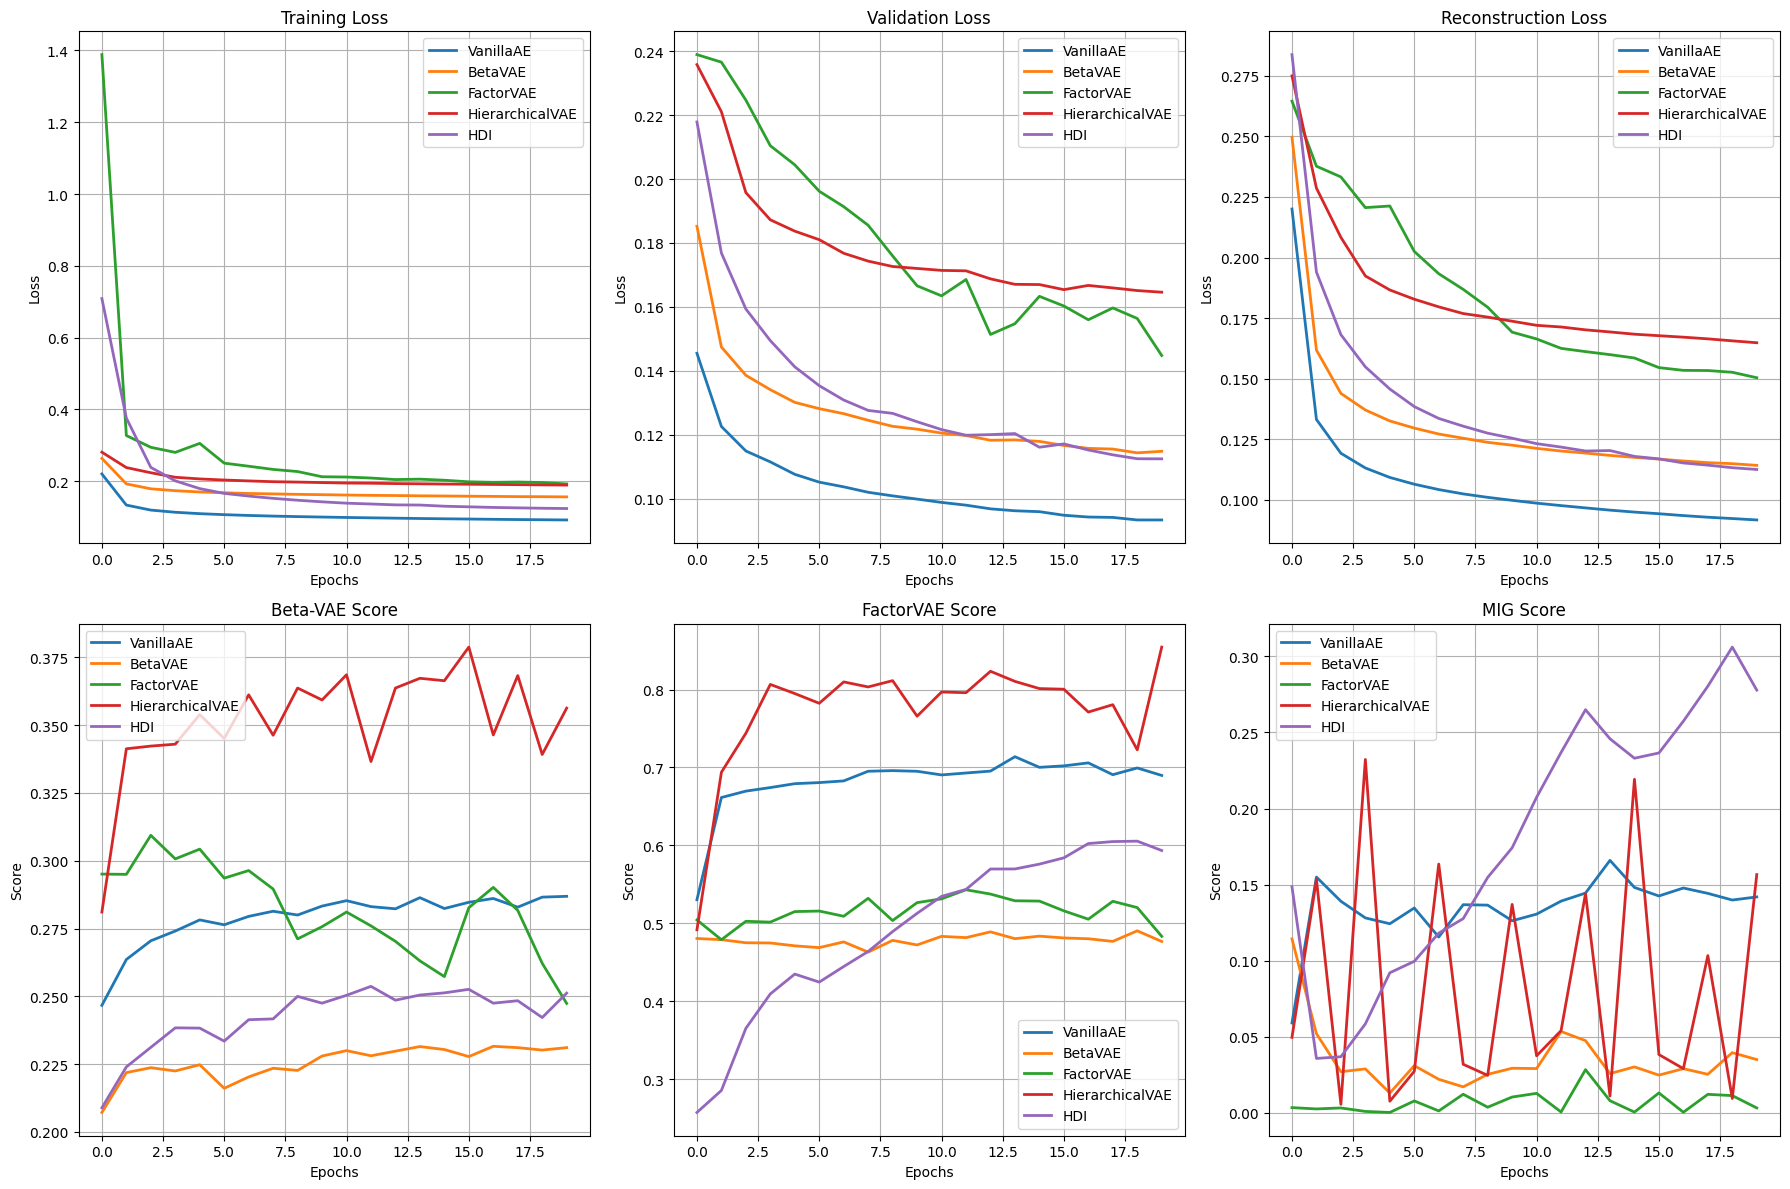

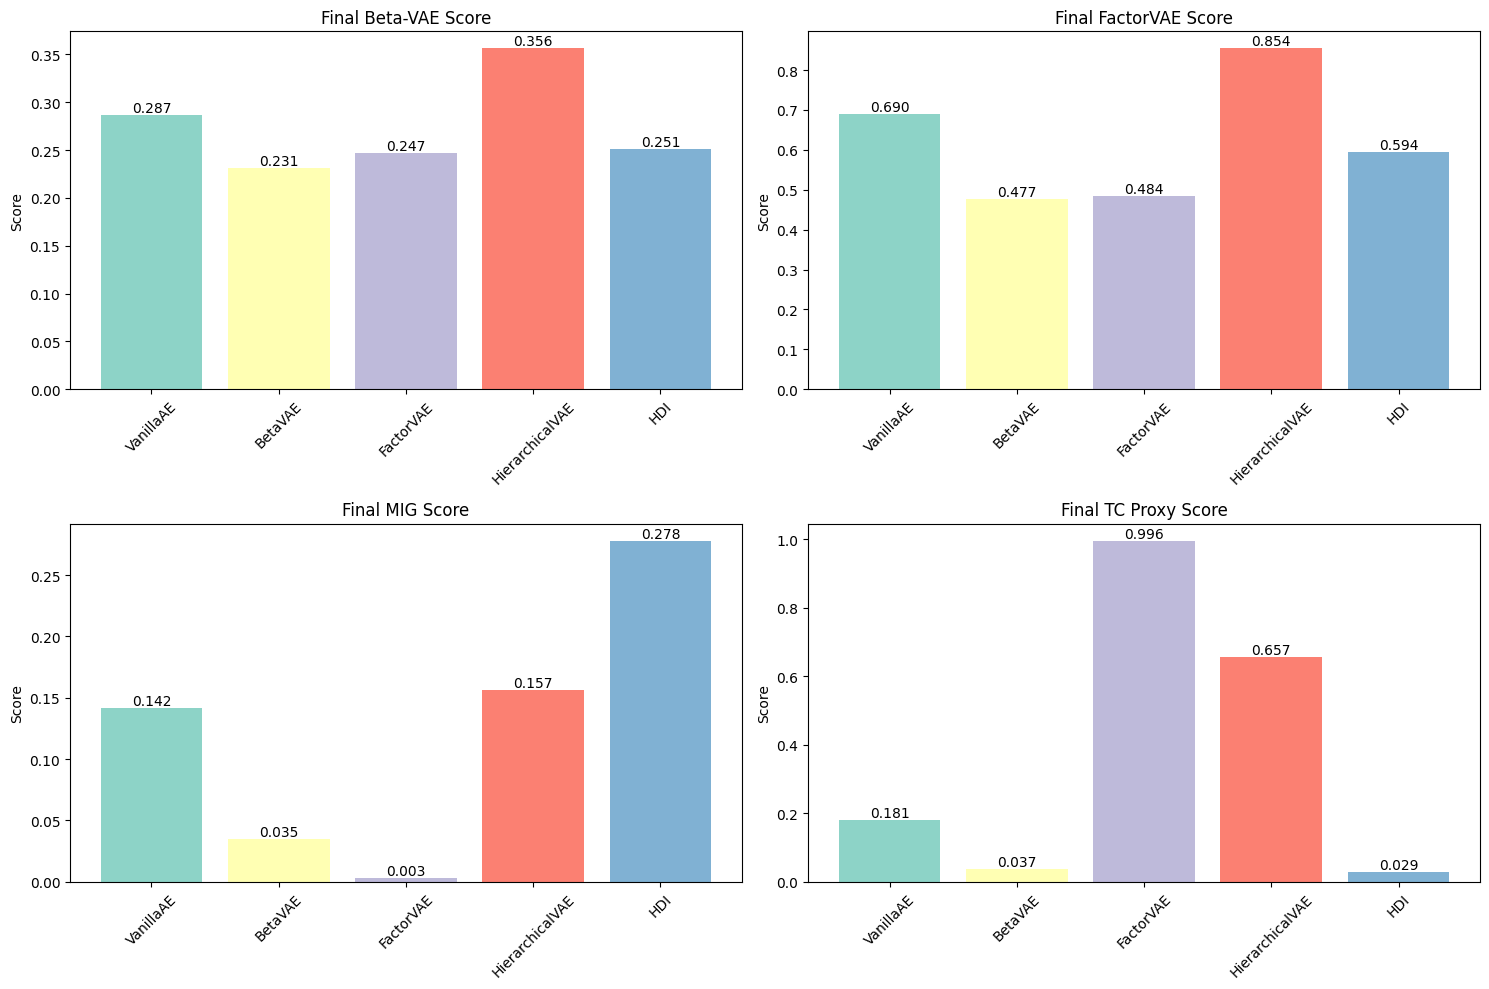

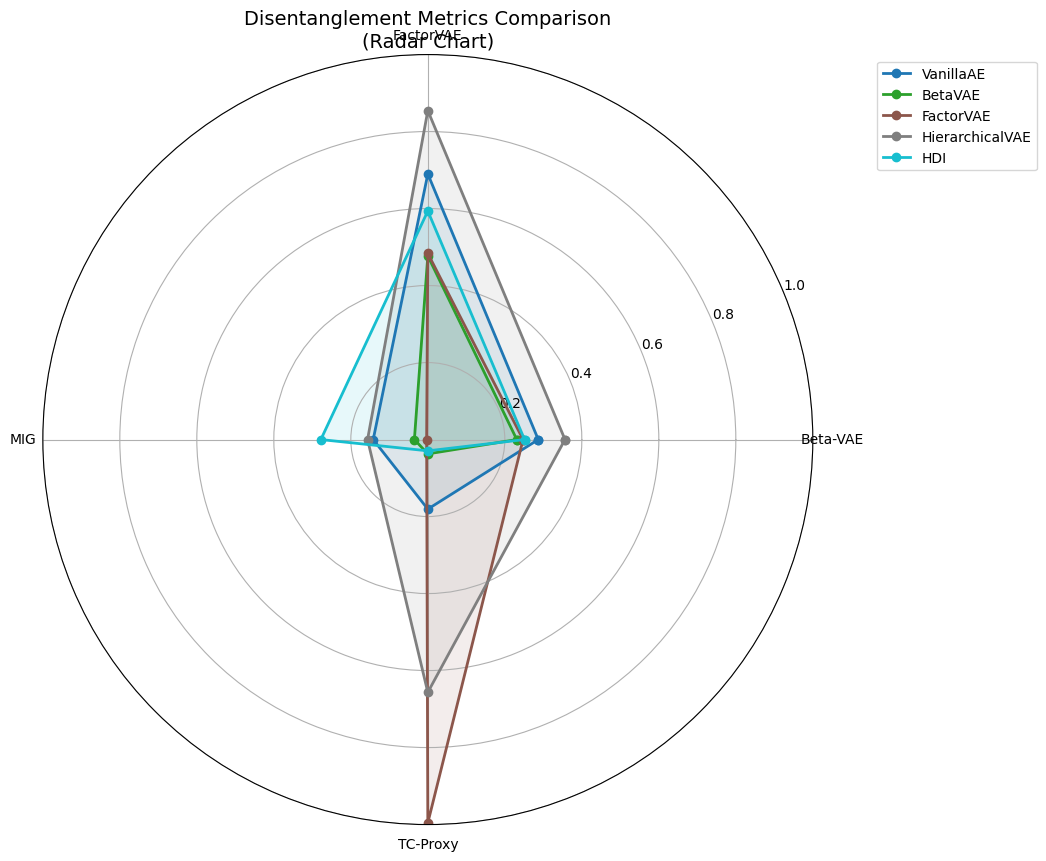

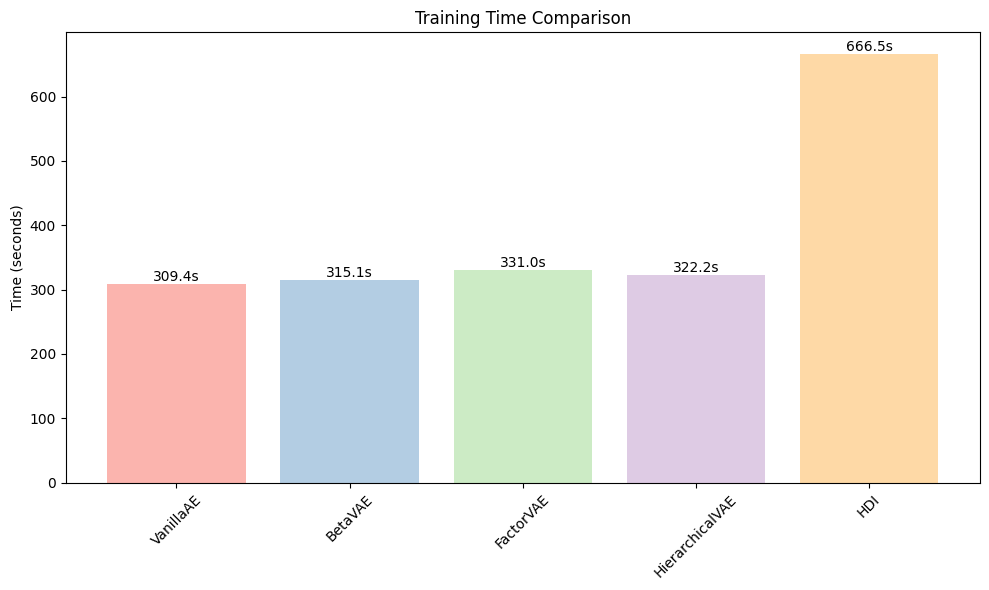


COMPREHENSIVE MODEL COMPARISON RESULTS
Model           Train Time   Beta-VAE    FactorVAE   MIG         TC-Proxy    
--------------------------------------------------------------------------------
VanillaAE       309.4s       0.2869      0.6898      0.1419      0.1807      
BetaVAE         315.1s       0.2311      0.4769      0.0349      0.0372      
FactorVAE       331.0s       0.2474      0.4835      0.0031      0.9956      
HierarchicalVAE 322.2s       0.3563      0.8544      0.1565      0.6566      
HDI             666.5s       0.2512      0.5936      0.2779      0.0293      
HDI Beta-VAE score: 0.2512
Training time for FactorVAE: 331.04s


In [ ]:
# Run the complete comparison
comparator = main()

# Access individual results
print(f"HDI Beta-VAE score: {comparator.histories['HDI']['beta_vae_score'][-1]:.4f}")
print(f"Training time for FactorVAE: {comparator.training_times['FactorVAE']:.2f}s")

# Save results for paper
import pickle
with open('model_comparison_results.pkl', 'wb') as f:
    pickle.dump({
        'histories': comparator.histories,
        'training_times': comparator.training_times
    }, f)

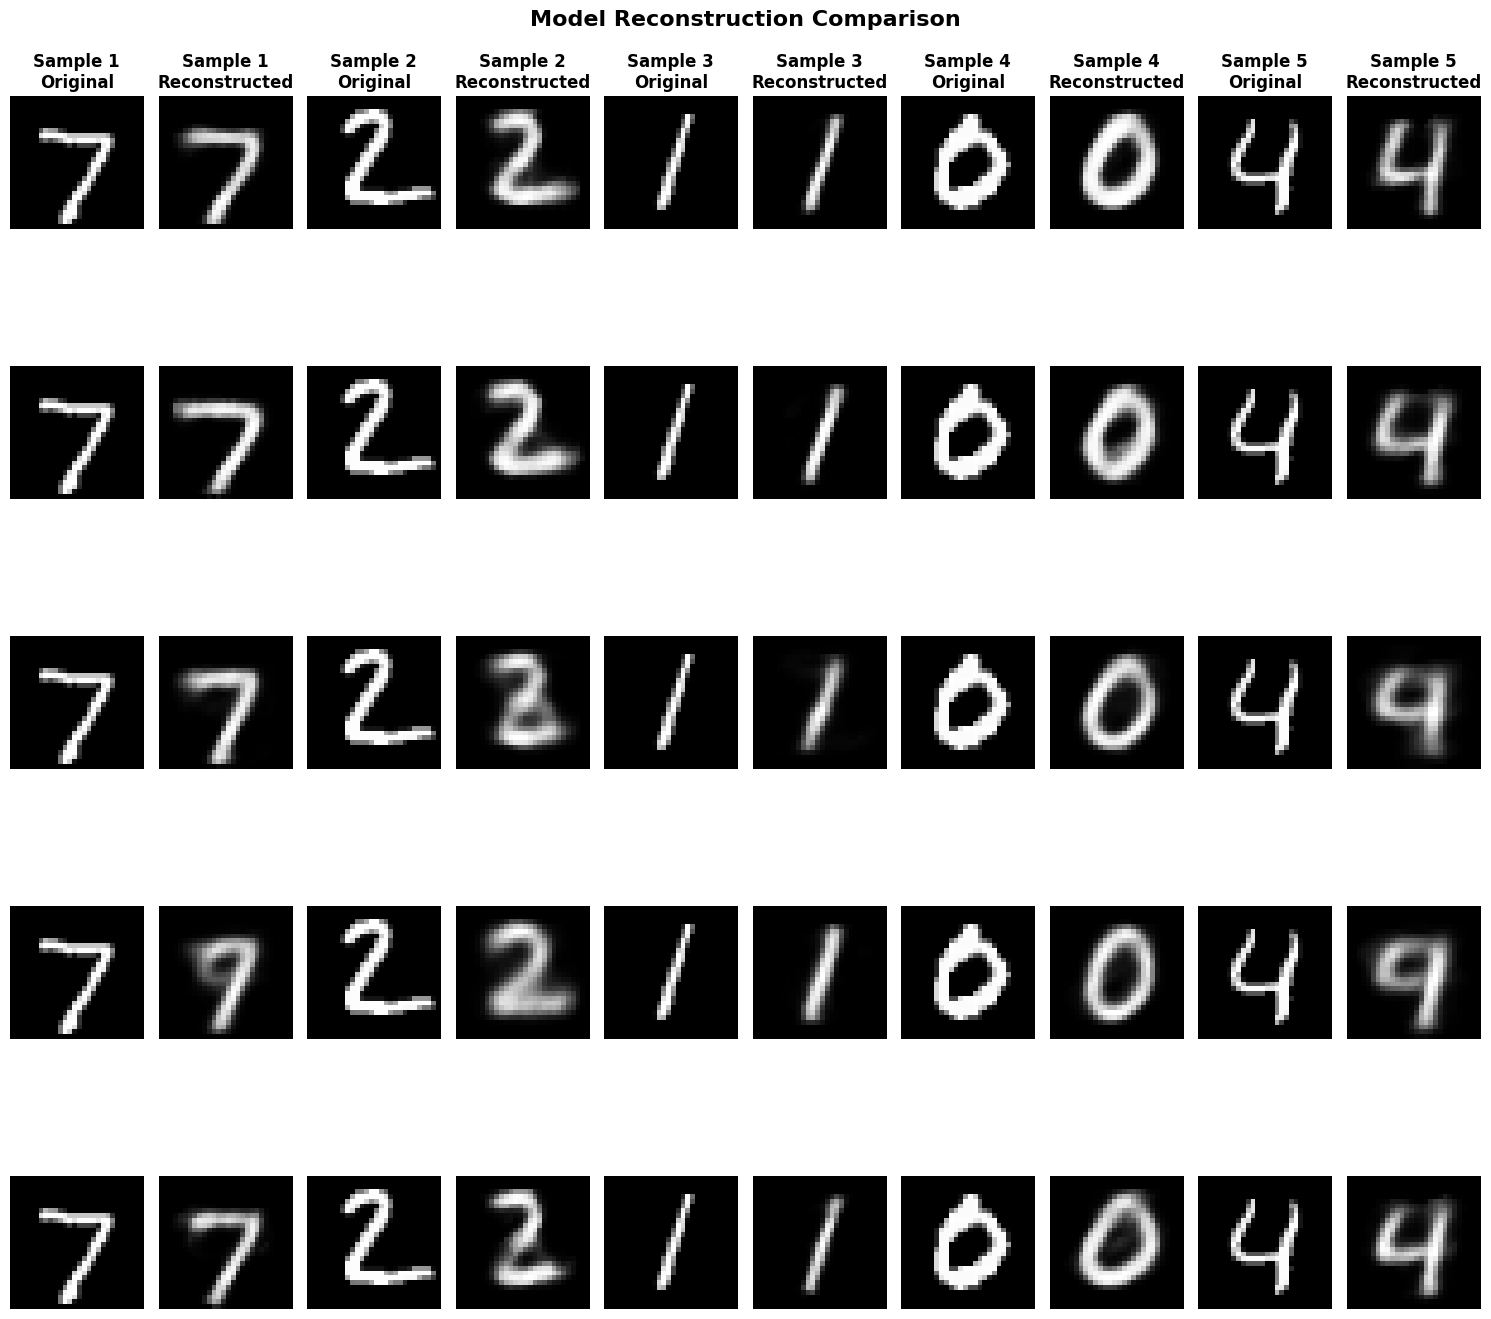

Computing latent space visualizations...
  Processing VanillaAE...
    Computing PCA for VanillaAE...
    Computing t-SNE for VanillaAE...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


  Processing BetaVAE...
    Computing PCA for BetaVAE...
    Computing t-SNE for BetaVAE...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


  Processing FactorVAE...
    Computing PCA for FactorVAE...
    Computing t-SNE for FactorVAE...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


  Processing HierarchicalVAE...
    Computing PCA for HierarchicalVAE...
    Computing t-SNE for HierarchicalVAE...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


  Processing HDI...
    Computing PCA for HDI...
    Computing t-SNE for HDI...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


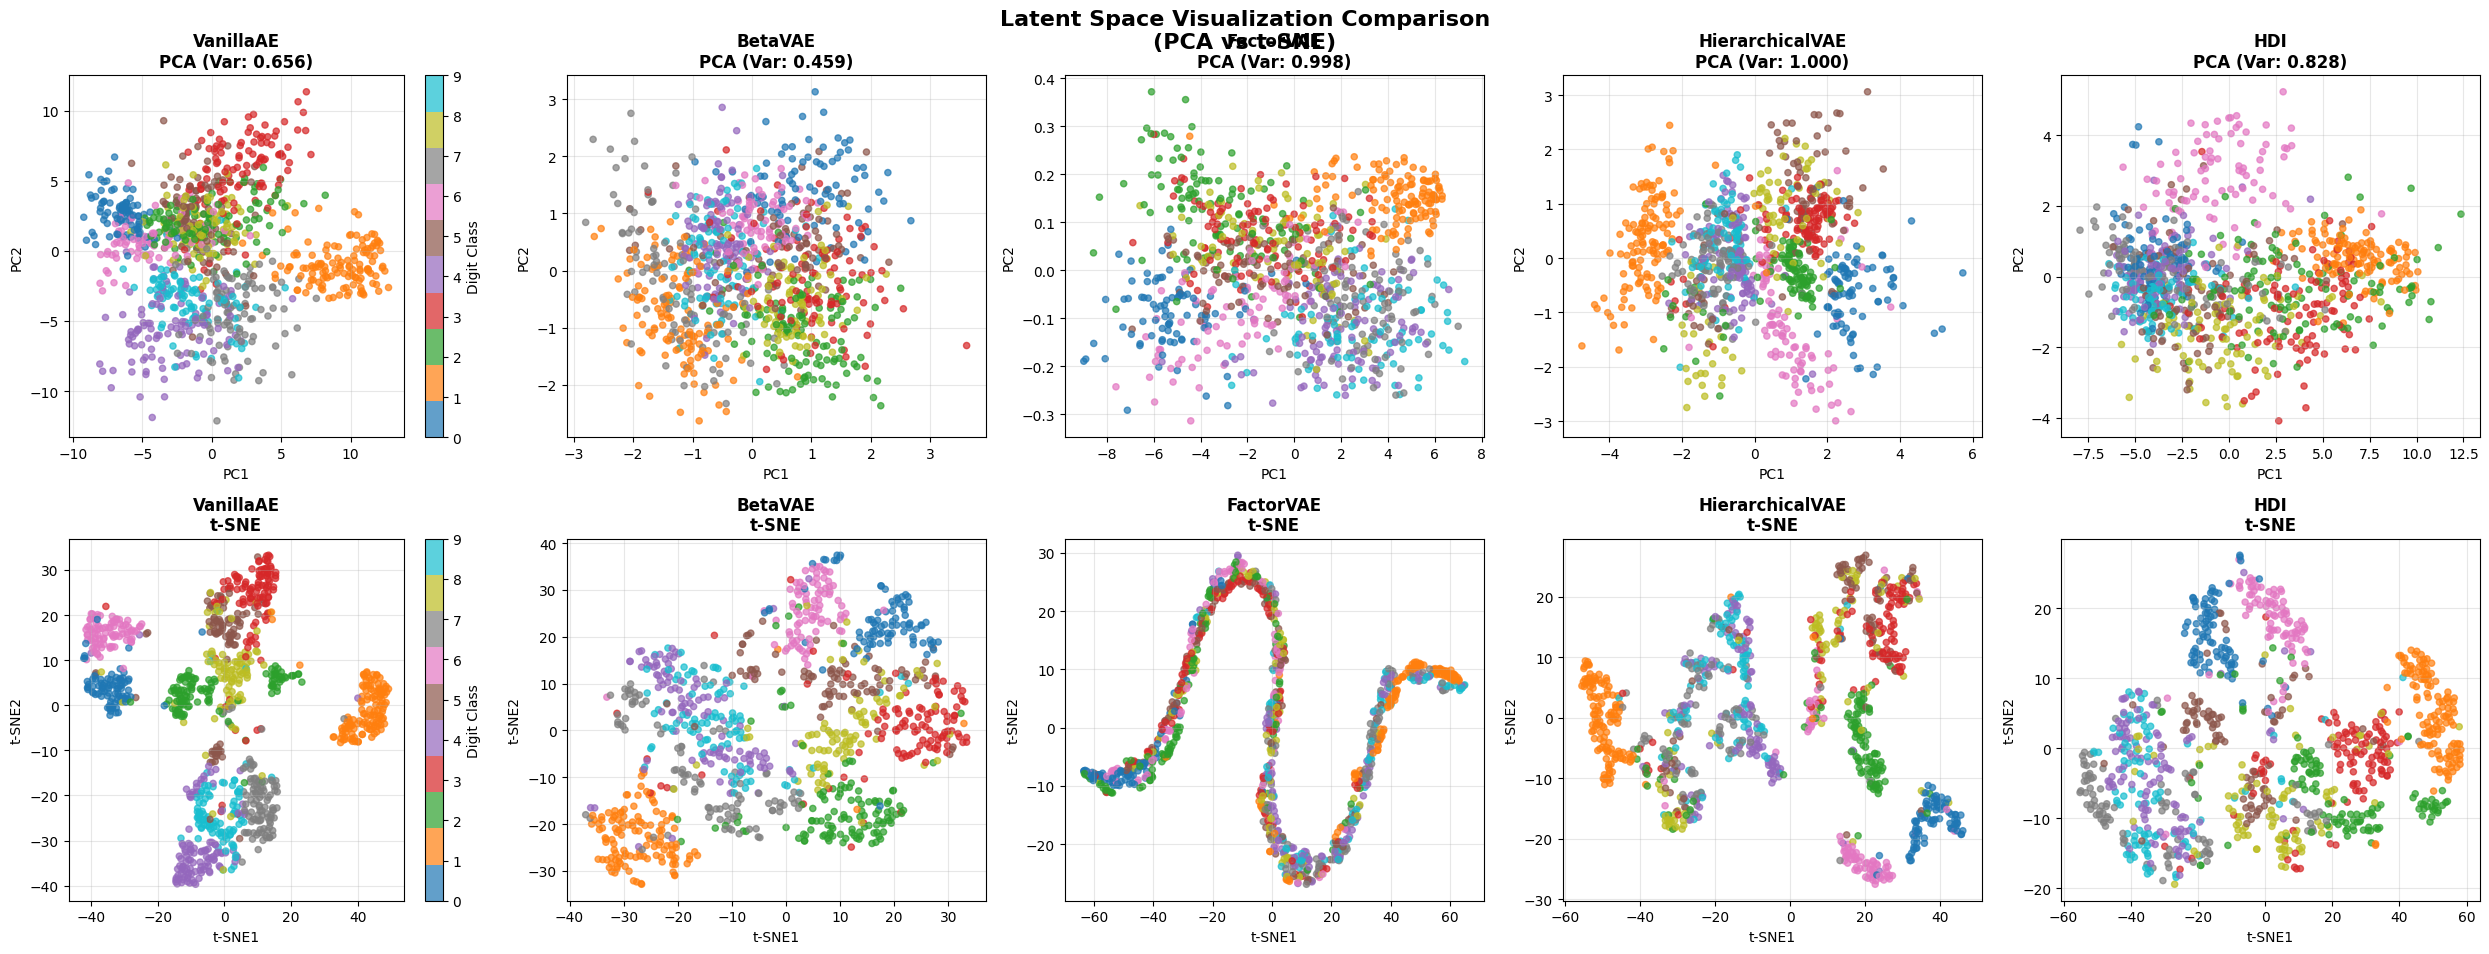

Computing comprehensive latent space analysis...
  Analyzing VanillaAE...
  Analyzing BetaVAE...
  Analyzing FactorVAE...
  Analyzing HierarchicalVAE...
  Analyzing HDI...


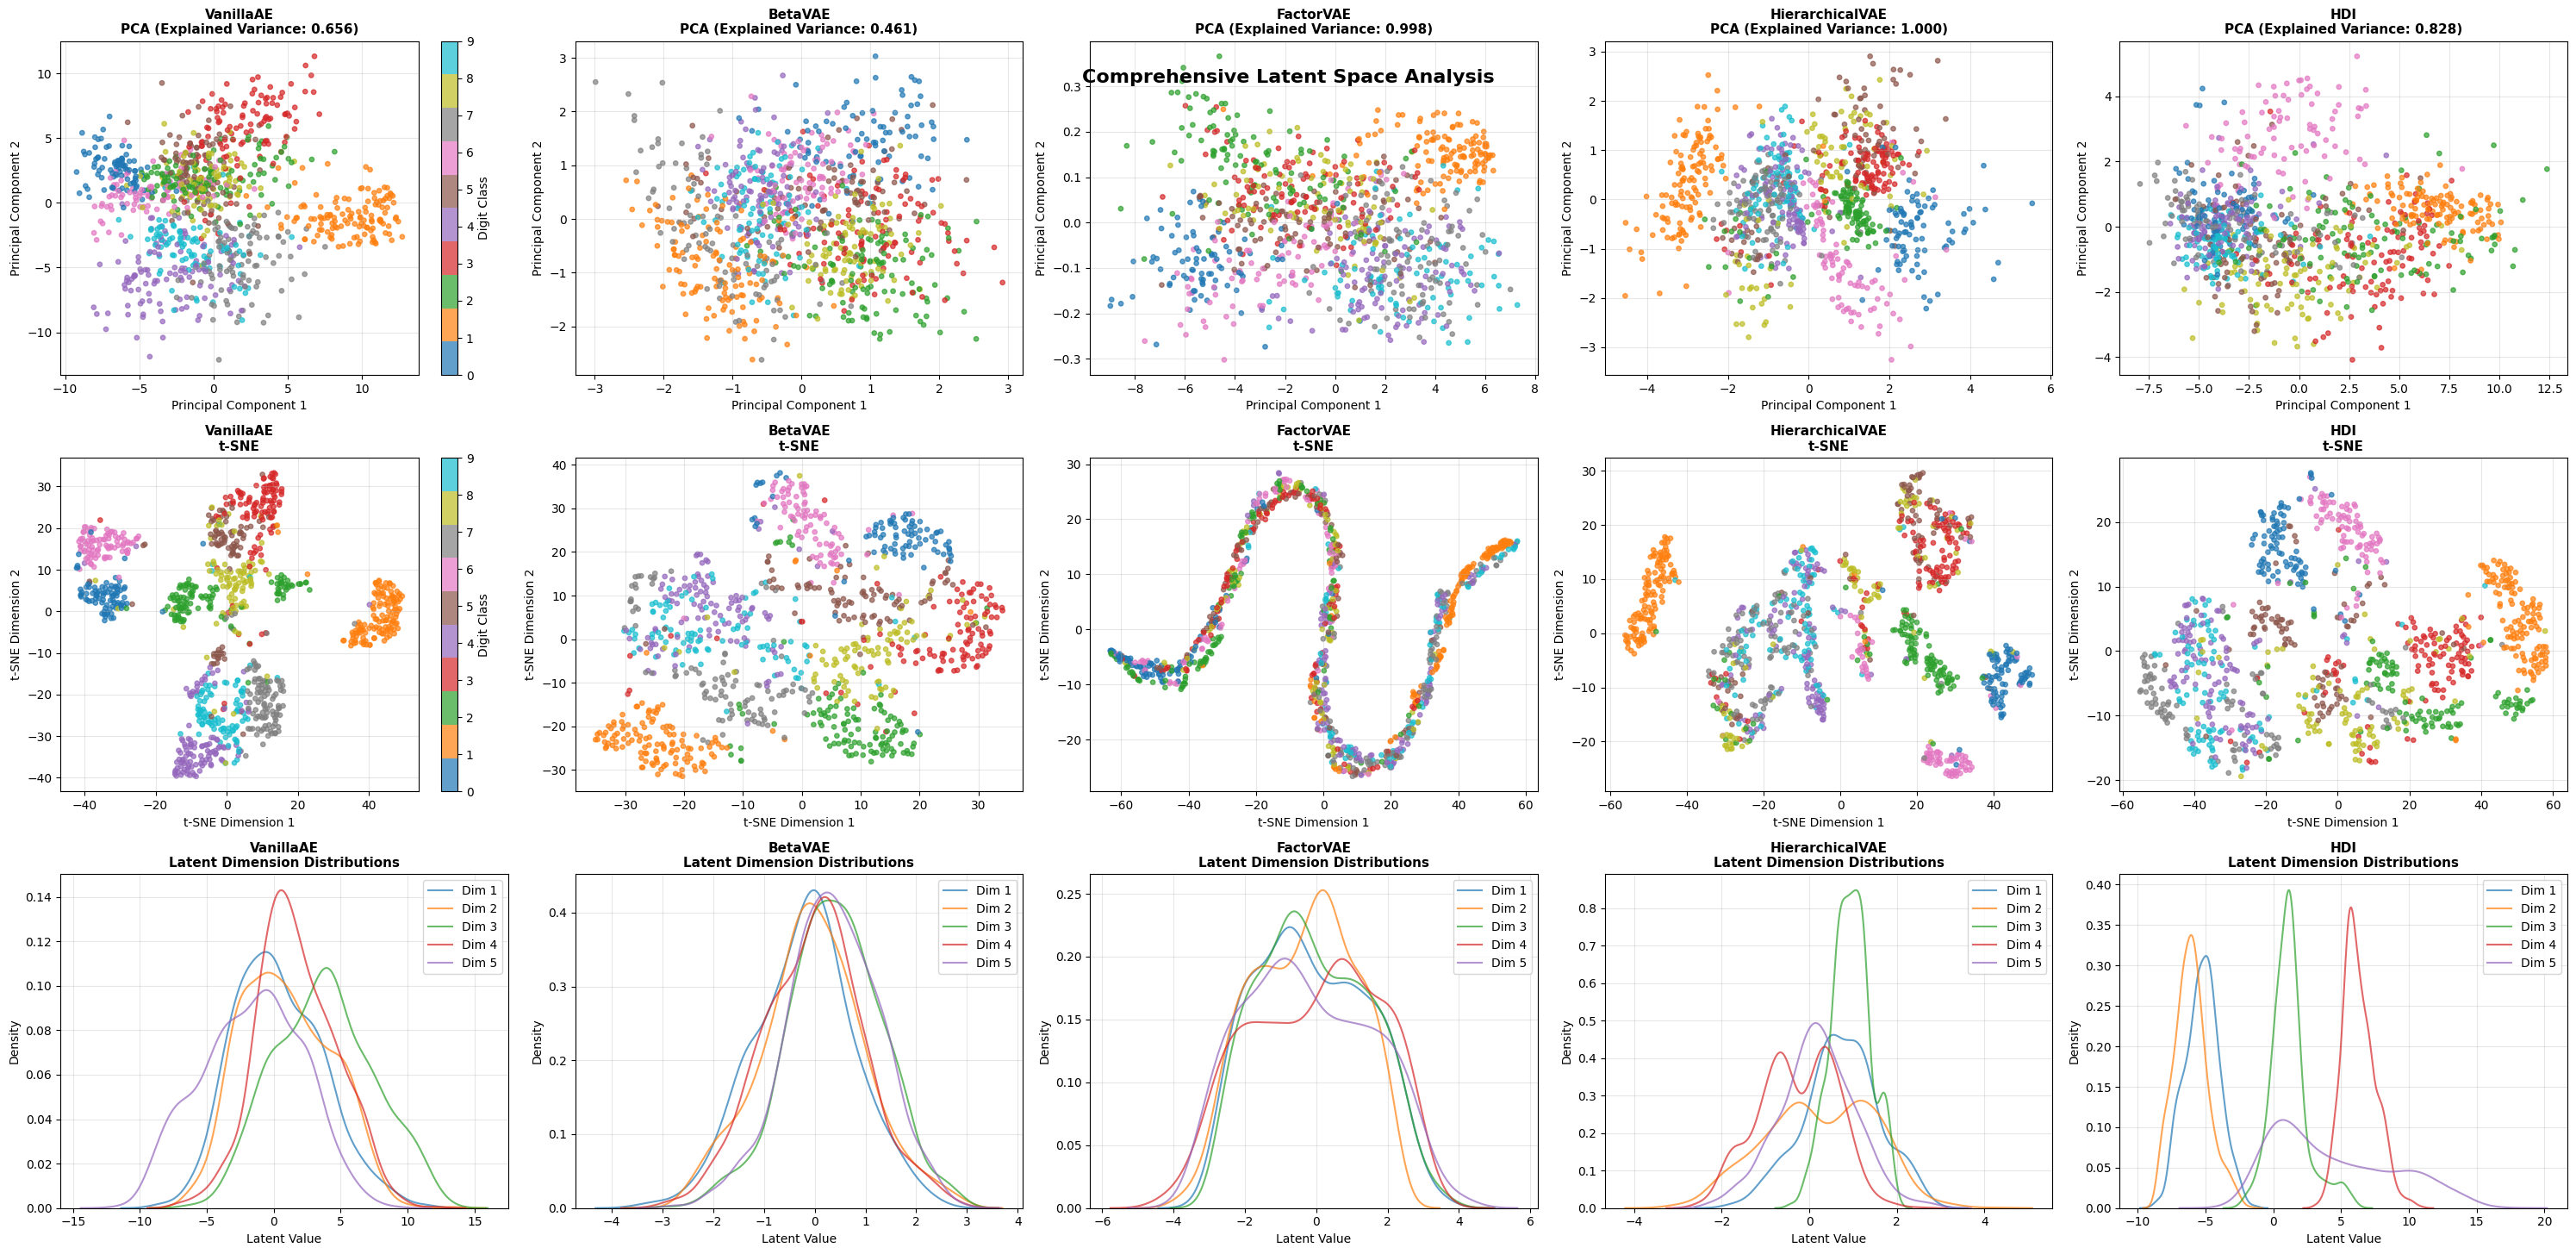

In [ ]:
def plot_sample_reconstructions(comparator, test_loader, num_samples=5, device=None):
    """Plot sample reconstructions from all models"""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    num_models = len(comparator.models)
    fig, axes = plt.subplots(num_models, num_samples * 2, figsize=(15, 3 * num_models))

    # Handle single model case
    if num_models == 1:
        axes = [axes]

    # Get a batch of test images
    images, labels = next(iter(test_loader))
    images = images[:num_samples]
    labels = labels[:num_samples]

    for row_idx, (model_name, model) in enumerate(comparator.models.items()):
        model.eval()
        with torch.no_grad():
            images_flat = images.view(images.size(0), -1).to(device)

            # All models now return 4 values: reconstructed, latent, mu, logvar
            if model_name == 'VanillaAE':
                reconstructed, _, _, _ = model(images_flat)
            elif model_name == 'BetaVAE':
                reconstructed, _, _, _ = model(images_flat)
            elif model_name == 'FactorVAE':
                reconstructed, _, _, _ = model(images_flat)
            elif model_name == 'HierarchicalVAE':
                reconstructed, _, _, _ = model(images_flat)
            elif model_name == 'HDI':
                reconstructed, _, _, _ = model(images_flat)

            # Reshape reconstructions
            reconstructed = reconstructed.view(-1, 28, 28).cpu()

        # Plot original and reconstructed images
        for col_idx in range(num_samples):
            # Original images (left column)
            ax_orig = axes[row_idx][2 * col_idx]
            ax_orig.imshow(images[col_idx].squeeze(), cmap='gray')
            if col_idx == 0:
                ax_orig.set_ylabel(model_name, rotation=0, ha='right', va='center', fontsize=12, fontweight='bold')
            ax_orig.set_title(f'Label: {labels[col_idx].item()}' if row_idx == 0 else '')
            ax_orig.axis('off')

            # Reconstructed images (right column)
            ax_recon = axes[row_idx][2 * col_idx + 1]
            ax_recon.imshow(reconstructed[col_idx].squeeze(), cmap='gray')
            # Calculate reconstruction error for this sample
            mse = torch.mean((images[col_idx].squeeze() - reconstructed[col_idx].squeeze()) ** 2).item()
            if row_idx == 0:
                ax_recon.set_title(f'MSE: {mse:.4f}')
            ax_recon.axis('off')

    # Add column labels
    for col_idx in range(num_samples):
        axes[0][2 * col_idx].set_title(f'Sample {col_idx + 1}\nOriginal', fontweight='bold')
        axes[0][2 * col_idx + 1].set_title(f'Sample {col_idx + 1}\nReconstructed', fontweight='bold')

    plt.suptitle('Model Reconstruction Comparison', fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.show()

    return fig

    #################

def plot_latent_space_comparison(comparator, test_loader, n_samples=1000, device=None):
    """Plot 2D visualization of latent spaces using PCA/t-SNE"""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE

    num_models = len(comparator.models)
    fig, axes = plt.subplots(2, num_models, figsize=(5 * num_models, 10))

    # Handle single model case
    if num_models == 1:
        axes = axes.reshape(2, 1)

    # Get test data
    all_images = []
    all_labels = []
    for images, labels in test_loader:
        all_images.append(images)
        all_labels.append(labels)
        if len(torch.cat(all_images)) >= n_samples:
            break

    images = torch.cat(all_images)[:n_samples]
    labels = torch.cat(all_labels)[:n_samples]
    images_flat = images.view(images.size(0), -1).to(device)

    print("Computing latent space visualizations...")

    for col_idx, (model_name, model) in enumerate(comparator.models.items()):
        print(f"  Processing {model_name}...")
        model.eval()
        with torch.no_grad():
            # Get latent representations - ALL models return 4 values
            if model_name == 'VanillaAE':
                _, latent, _, _ = model(images_flat)
                latent = latent.squeeze(0)  # Remove level dimension
            elif model_name == 'BetaVAE':
                _, latent, _, _ = model(images_flat)
                latent = latent.squeeze(0)
            elif model_name == 'FactorVAE':
                _, latent, _, _ = model(images_flat)
                latent = latent.squeeze(0)
            elif model_name == 'HierarchicalVAE':
                _, latent, _, _ = model(images_flat)
                latent = latent[-1]  # Use last level
            elif model_name == 'HDI':
                _, HDI_levels, _, _ = model(images_flat)
                latent = HDI_levels[0]  # Use first level

            latent_np = latent.cpu().numpy()

        # PCA Visualization
        print(f"    Computing PCA for {model_name}...")
        pca = PCA(n_components=2, random_state=42)
        latent_pca = pca.fit_transform(latent_np)
        explained_variance = pca.explained_variance_ratio_.sum()

        # Plot PCA
        scatter1 = axes[0, col_idx].scatter(latent_pca[:, 0], latent_pca[:, 1],
                                          c=labels, cmap='tab10', alpha=0.7, s=20)
        axes[0, col_idx].set_title(f'{model_name}\nPCA (Var: {explained_variance:.3f})',
                                 fontweight='bold', fontsize=12)
        axes[0, col_idx].set_xlabel('PC1')
        axes[0, col_idx].set_ylabel('PC2')
        axes[0, col_idx].grid(True, alpha=0.3)

        # t-SNE Visualization
        print(f"    Computing t-SNE for {model_name}...")
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
        latent_tsne = tsne.fit_transform(latent_np)

        # Plot t-SNE
        scatter2 = axes[1, col_idx].scatter(latent_tsne[:, 0], latent_tsne[:, 1],
                                          c=labels, cmap='tab10', alpha=0.7, s=20)
        axes[1, col_idx].set_title(f'{model_name}\nt-SNE', fontweight='bold', fontsize=12)
        axes[1, col_idx].set_xlabel('t-SNE1')
        axes[1, col_idx].set_ylabel('t-SNE2')
        axes[1, col_idx].grid(True, alpha=0.3)

        # Add colorbar for the first column only
        if col_idx == 0:
            plt.colorbar(scatter1, ax=axes[0, col_idx], label='Digit Class')
            plt.colorbar(scatter2, ax=axes[1, col_idx], label='Digit Class')

    plt.suptitle('Latent Space Visualization Comparison\n(PCA vs t-SNE)',
                fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.show()

    return fig

    #################

def plot_comprehensive_latent_analysis(comparator, test_loader, n_samples=1000, device=None):
    """Comprehensive latent space analysis with multiple visualization techniques"""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    import seaborn as sns

    num_models = len(comparator.models)
    fig = plt.figure(figsize=(6 * num_models, 15))

    # Create subplot grid: 3 rows (PCA, t-SNE, Histograms) × num_models columns
    gs = plt.GridSpec(3, num_models, figure=fig)

    # Get test data
    all_images = []
    all_labels = []
    for images, labels in test_loader:
        all_images.append(images)
        all_labels.append(labels)
        if len(torch.cat(all_images)) >= n_samples:
            break

    images = torch.cat(all_images)[:n_samples]
    labels = torch.cat(all_labels)[:n_samples]
    images_flat = images.view(images.size(0), -1).to(device)

    print("Computing comprehensive latent space analysis...")

    for col_idx, (model_name, model) in enumerate(comparator.models.items()):
        print(f"  Analyzing {model_name}...")
        model.eval()
        with torch.no_grad():
            # Get latent representations
            if model_name == 'VanillaAE':
                _, latent, _, _ = model(images_flat)
                latent = latent.squeeze(0)
            elif model_name == 'BetaVAE':
                _, latent, _, _ = model(images_flat)
                latent = latent.squeeze(0)
            elif model_name == 'FactorVAE':
                _, latent, _, _ = model(images_flat)
                latent = latent.squeeze(0)
            elif model_name == 'HierarchicalVAE':
                _, latent, _, _ = model(images_flat)
                latent = latent[-1]
            elif model_name == 'HDI':
                _, HDI_levels, _, _ = model(images_flat)
                latent = HDI_levels[0]

            latent_np = latent.cpu().numpy()

        # Row 1: PCA
        ax1 = fig.add_subplot(gs[0, col_idx])
        pca = PCA(n_components=2, random_state=42)
        latent_pca = pca.fit_transform(latent_np)
        explained_variance = pca.explained_variance_ratio_.sum()

        scatter1 = ax1.scatter(latent_pca[:, 0], latent_pca[:, 1],
                             c=labels, cmap='tab10', alpha=0.7, s=15)
        ax1.set_title(f'{model_name}\nPCA (Explained Variance: {explained_variance:.3f})',
                    fontweight='bold', fontsize=11)
        ax1.set_xlabel('Principal Component 1')
        ax1.set_ylabel('Principal Component 2')
        ax1.grid(True, alpha=0.3)

        # Row 2: t-SNE
        ax2 = fig.add_subplot(gs[1, col_idx])
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        latent_tsne = tsne.fit_transform(latent_np)

        scatter2 = ax2.scatter(latent_tsne[:, 0], latent_tsne[:, 1],
                             c=labels, cmap='tab10', alpha=0.7, s=15)
        ax2.set_title(f'{model_name}\nt-SNE', fontweight='bold', fontsize=11)
        ax2.set_xlabel('t-SNE Dimension 1')
        ax2.set_ylabel('t-SNE Dimension 2')
        ax2.grid(True, alpha=0.3)

        # Row 3: Latent Dimension Distributions
        ax3 = fig.add_subplot(gs[2, col_idx])
        # Plot distribution of first few latent dimensions
        n_dims_to_plot = min(5, latent_np.shape[1])
        for dim in range(n_dims_to_plot):
            sns.kdeplot(latent_np[:, dim], ax=ax3, label=f'Dim {dim+1}', alpha=0.7)

        ax3.set_title(f'{model_name}\nLatent Dimension Distributions',
                     fontweight='bold', fontsize=11)
        ax3.set_xlabel('Latent Value')
        ax3.set_ylabel('Density')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # Add colorbar for first column
        if col_idx == 0:
            plt.colorbar(scatter1, ax=ax1, label='Digit Class')
            plt.colorbar(scatter2, ax=ax2, label='Digit Class')

    plt.suptitle('Comprehensive Latent Space Analysis',
                fontsize=16, fontweight='bold', y=0.92)
    plt.tight_layout()
    plt.show()

    return fig

##############################################
# After training your models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Plot reconstructions
fig1 = plot_sample_reconstructions(comparator, test_loader, num_samples=5, device=device)

# Plot latent space comparison
fig2 = plot_latent_space_comparison(comparator, test_loader, n_samples=1000, device=device)

# Optional: Comprehensive analysis
fig3 = plot_comprehensive_latent_analysis(comparator, test_loader, n_samples=1000, device=device)

# Save figures for paper
fig1.savefig('reconstruction_comparison.png', dpi=300, bbox_inches='tight')
fig2.savefig('latent_space_comparison.png', dpi=300, bbox_inches='tight')
fig3.savefig('comprehensive_analysis.png', dpi=300, bbox_inches='tight')


In [ ]:
#################### HDS

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

class UnifiedModelComparator:
    def __init__(self, config, device):
        self.config = config
        self.device = device
        self.models = {}
        self.histories = {}
        self.training_times = {}

    def initialize_models(self):
        """Initialize all models with consistent interface"""
        self.models = {
            'VanillaAE': self._create_vanilla_ae(),
            'BetaVAE': self._create_beta_vae(),
            'FactorVAE': self._create_factor_vae(),
            'HierarchicalVAE': self._create_hierarchical_vae(),
            'HDI': self._create_hdi_model()
        }

    def _create_vanilla_ae(self):
        """Create Vanilla Autoencoder"""
        class VanillaAE(nn.Module):
            def __init__(self, input_dim, hidden_dim, BN_dim):
                super().__init__()
                self.encoder = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(input_dim, hidden_dim[0]),
                    nn.ReLU(),
                    nn.Linear(hidden_dim[0], hidden_dim[1]),
                    nn.ReLU(),
                    nn.Linear(hidden_dim[1], BN_dim)
                )
                self.decoder = nn.Sequential(
                    nn.Linear(BN_dim, hidden_dim[1]),
                    nn.ReLU(),
                    nn.Linear(hidden_dim[1], hidden_dim[0]),
                    nn.ReLU(),
                    nn.Linear(hidden_dim[0], input_dim),
                    nn.Tanh()
                )

            def forward(self, x):
                z = self.encoder(x)
                reconstructed = self.decoder(z)
                return reconstructed, z.unsqueeze(0), None, None

        return VanillaAE(self.config.input_dim, self.config.hidden_dim, self.config.BN_dim).to(self.device)

    def _create_beta_vae(self):
        """Create Beta-VAE"""
        class BetaVAE(nn.Module):
            def __init__(self, input_dim, hidden_dim, BN_dim):
                super().__init__()
                self.BN_dim = BN_dim
                self.encoder = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(input_dim, hidden_dim[0]),
                    nn.ReLU(),
                    nn.Linear(hidden_dim[0], hidden_dim[1]),
                    nn.ReLU(),
                )
                self.fc_mu = nn.Linear(hidden_dim[1], BN_dim)
                self.fc_logvar = nn.Linear(hidden_dim[1], BN_dim)
                self.decoder = nn.Sequential(
                    nn.Linear(BN_dim, hidden_dim[1]),
                    nn.ReLU(),
                    nn.Linear(hidden_dim[1], hidden_dim[0]),
                    nn.ReLU(),
                    nn.Linear(hidden_dim[0], input_dim),
                    nn.Tanh()
                )

            def reparameterize(self, mu, logvar):
                std = torch.exp(0.5 * logvar)
                eps = torch.randn_like(std)
                return mu + eps * std

            def forward(self, x):
                h = self.encoder(x)
                mu, logvar = self.fc_mu(h), self.fc_logvar(h)
                z = self.reparameterize(mu, logvar)
                reconstructed = self.decoder(z)
                return reconstructed, z.unsqueeze(0), mu, logvar

        return BetaVAE(self.config.input_dim, self.config.hidden_dim, self.config.BN_dim).to(self.device)

    def _create_factor_vae(self):
        """Create FactorVAE"""
        class FactorVAE(nn.Module):
            def __init__(self, input_dim, hidden_dim, BN_dim):
                super().__init__()
                self.BN_dim = BN_dim
                self.encoder = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(input_dim, hidden_dim[0]),
                    nn.ReLU(),
                    nn.Linear(hidden_dim[0], hidden_dim[1]),
                    nn.ReLU(),
                )
                self.fc_mu = nn.Linear(hidden_dim[1], BN_dim)
                self.fc_logvar = nn.Linear(hidden_dim[1], BN_dim)
                self.decoder = nn.Sequential(
                    nn.Linear(BN_dim, hidden_dim[1]),
                    nn.ReLU(),
                    nn.Linear(hidden_dim[1], hidden_dim[0]),
                    nn.ReLU(),
                    nn.Linear(hidden_dim[0], input_dim),
                    nn.Tanh()
                )
                self.discriminator = nn.Sequential(
                    nn.Linear(BN_dim, hidden_dim[1]),
                    nn.LeakyReLU(0.2),
                    nn.Linear(hidden_dim[1], hidden_dim[0]),
                    nn.LeakyReLU(0.2),
                    nn.Linear(hidden_dim[0], 2),
                )

            def reparameterize(self, mu, logvar):
                std = torch.exp(0.5 * logvar)
                eps = torch.randn_like(std)
                return mu + eps * std

            def forward(self, x):
                h = self.encoder(x)
                mu, logvar = self.fc_mu(h), self.fc_logvar(h)
                z = self.reparameterize(mu, logvar)
                reconstructed = self.decoder(z)
                return reconstructed, z.unsqueeze(0), mu, logvar

        return FactorVAE(self.config.input_dim, self.config.hidden_dim, self.config.BN_dim).to(self.device)

    def _create_hierarchical_vae(self):
        """Create Hierarchical VAE"""
        class HierarchicalVAE(nn.Module):
            def __init__(self, input_dim, hidden_dim, BN_dim, levels):
                super().__init__()
                self.levels = levels
                self.BN_dim = BN_dim
                self.encoder = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(input_dim, hidden_dim[0]),
                    nn.ReLU(),
                    nn.Linear(hidden_dim[0], hidden_dim[1]),
                    nn.ReLU(),
                    nn.Linear(hidden_dim[1], BN_dim * 2)
                )
                self.hierarchical_mapping = nn.ModuleList([
                    nn.Linear(BN_dim, BN_dim) for _ in range(levels - 1)
                ])
                self.decoder = nn.Sequential(
                    nn.Linear(BN_dim, hidden_dim[1]),
                    nn.ReLU(),
                    nn.Linear(hidden_dim[1], hidden_dim[0]),
                    nn.ReLU(),
                    nn.Linear(hidden_dim[0], input_dim),
                    nn.Tanh()
                )

            def reparameterize(self, mu, logvar):
                std = torch.exp(0.5 * logvar)
                eps = torch.randn_like(std)
                return mu + eps * std

            def forward(self, x):
                h = self.encoder(x)
                mu_logvar = h.view(-1, 2, self.BN_dim)
                mu, logvar = mu_logvar[:, 0], mu_logvar[:, 1]
                z0 = self.reparameterize(mu, logvar)

                hierarchical_z = [z0.unsqueeze(0)]
                current_z = z0
                for mapping in self.hierarchical_mapping:
                    current_z = mapping(current_z)
                    hierarchical_z.append(current_z.unsqueeze(0))

                z_hierarchical = torch.cat(hierarchical_z, dim=0)
                reconstructed = self.decoder(z_hierarchical[-1])
                return reconstructed, z_hierarchical, mu, logvar

        return HierarchicalVAE(self.config.input_dim, self.config.hidden_dim,
                              self.config.BN_dim, self.config.levels).to(self.device)

    def _create_hdi_model(self):
        """Create HDI Model"""
        class HDI_Model(nn.Module):
            def __init__(self, input_dim, hidden_dim, BN_dim, levels):
                super().__init__()
                self.encoder = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(input_dim, hidden_dim[0]),
                    nn.ReLU(),
                    nn.Linear(hidden_dim[0], hidden_dim[1]),
                    nn.ReLU(),
                    nn.Linear(hidden_dim[1], BN_dim)
                )
                self.bottleneck = HDI_model(levels, BN_dim)
                self.attention = nn.Sequential(
                    nn.Linear(BN_dim, 1),
                    nn.Softmax(dim=0)
                )
                self.decoder = nn.Sequential(
                    nn.Linear(BN_dim, hidden_dim[1]),
                    nn.ReLU(),
                    nn.Linear(hidden_dim[1], hidden_dim[0]),
                    nn.ReLU(),
                    nn.Linear(hidden_dim[0], input_dim),
                    nn.Tanh()
                )

            def forward(self, x, method="attention"):
                z = self.encoder(x)
                HDI_levels = self.bottleneck(z)

                if method == "attention":
                    attention_scores = self.attention(HDI_levels).squeeze(-1)
                    attention_scores = attention_scores.unsqueeze(-1)
                    weighted_output = (HDI_levels * attention_scores).sum(dim=0)
                else:
                    weighted_output = HDI_levels[0]

                reconstructed = self.decoder(weighted_output)
                return reconstructed, HDI_levels, None, None

        return HDI_Model(self.config.input_dim, self.config.hidden_dim,
                        self.config.BN_dim, self.config.levels).to(self.device)

    def train_all_models(self, train_loader, test_loader, num_epochs):
        """Train all models with consistent interface"""
        for model_name, model in self.models.items():
            print(f"\n{'='*50}")
            print(f"Training {model_name}")
            print(f"{'='*50}")

            start_time = time.time()
            history = self._train_single_model(
                model, model_name, train_loader, test_loader, num_epochs
            )
            training_time = time.time() - start_time

            self.histories[model_name] = history
            self.training_times[model_name] = training_time

            print(f"{model_name} training completed in {training_time:.2f} seconds")

    def _train_single_model(self, model, model_name, train_loader, test_loader, num_epochs):
        """Train a single model"""
        optimizer = optim.Adam(model.parameters(), lr=self.config.learning_rate)
        criterion = nn.MSELoss()

        history = {
            'train_loss': [], 'val_loss': [], 'reconstruction_loss': [],
            'beta_vae_score': [], 'factor_vae_score': [],
            'mig_score': [], 'tc_proxy_score': []
        }

        for epoch in range(num_epochs):
            # Training
            model.train()
            train_loss = 0
            reconstruction_loss = 0

            for batch_idx, (images, labels) in enumerate(train_loader):
                images = images.to(self.device)
                images_flat = images.view(images.size(0), -1)

                optimizer.zero_grad()

                # ALL models return: reconstructed, latent, mu, logvar
                reconstructed, latent, mu, logvar = model(images_flat)

                # Compute loss based on model type
                if model_name == 'VanillaAE':
                    loss = criterion(reconstructed, images_flat)
                    rec_loss = loss
                elif model_name in ['BetaVAE', 'HierarchicalVAE']:
                    loss, rec_loss, kl_loss = beta_vae_loss(
                        reconstructed, images_flat, mu, logvar, beta=4.0
                    )
                elif model_name == 'FactorVAE':
                    loss, rec_loss, kl_loss, tc_loss = factor_vae_loss(
                        reconstructed, images_flat, mu, logvar,
                        latent.squeeze(0), model.discriminator, gamma=6.0
                    )
                elif model_name == 'HDI':
                    loss, rec_loss, corr_loss, indep_loss, adj_loss = hdi_loss(
                        reconstructed, images_flat, latent,
                        self.config.target_correlations, self.config.target_dependence
                    )

                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                reconstruction_loss += rec_loss.item()

            # Validation
            val_loss = self._validate_model(model, test_loader, criterion)

            # Metrics
            metrics = self._compute_metrics(model, model_name, test_loader)

            # Update history
            history['train_loss'].append(train_loss / len(train_loader))
            history['val_loss'].append(val_loss)
            history['reconstruction_loss'].append(reconstruction_loss / len(train_loader))
            history['beta_vae_score'].append(metrics['beta_vae'])
            history['factor_vae_score'].append(metrics['factor_vae'])
            history['mig_score'].append(metrics['mig'])
            history['tc_proxy_score'].append(metrics['tc_proxy'])

            if epoch % 5 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, '
                      f'Train Loss: {history["train_loss"][-1]:.4f}, '
                      f'Val Loss: {history["val_loss"][-1]:.4f}, '
                      f'Beta-VAE: {metrics["beta_vae"]:.4f}')

        return history

    def _validate_model(self, model, test_loader, criterion):
        """Validate model"""
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(self.device)
                images_flat = images.view(images.size(0), -1)
                reconstructed, _, _, _ = model(images_flat)
                loss = criterion(reconstructed, images_flat)
                val_loss += loss.item()

        return val_loss / len(test_loader)

    def _compute_metrics(self, model, model_name, test_loader):
        """Compute metrics with consistent interface"""
        model.eval()
        all_latents = []
        all_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(self.device)
                images_flat = images.view(images.size(0), -1)

                # ALL models return: reconstructed, latent, mu, logvar
                _, latent, _, _ = model(images_flat)

                # Extract appropriate latent representation
                if model_name == 'HierarchicalVAE':
                    latent = latent[-1]  # Use last level
                else:
                    latent = latent.squeeze(0)  # Remove level dimension

                all_latents.append(latent.cpu().numpy())
                all_labels.append(labels.numpy())

        latent_codes = np.concatenate(all_latents, axis=0)
        labels = np.concatenate(all_labels, axis=0)

        metrics = {
            'beta_vae': beta_vae_metric(latent_codes, labels),
            'factor_vae': factor_vae_metric(latent_codes, labels),
            'mig': mutual_information_gap(latent_codes, labels),
            'tc_proxy': total_correlation_proxy(latent_codes)
        }

        return metrics

    def plot_comparison_results(self):
        """Plot comprehensive comparison results"""
        self._plot_training_curves()
        self._plot_metric_comparison()
        self._plot_final_scores()
        self._plot_training_times()


    def print_comparison_table(self):
        """Print comprehensive comparison table"""
        print("\n" + "="*80)
        print("COMPREHENSIVE MODEL COMPARISON RESULTS")
        print("="*80)

        metrics = ['beta_vae_score', 'factor_vae_score', 'mig_score', 'tc_proxy_score']
        metric_names = ['Beta-VAE', 'FactorVAE', 'MIG', 'TC-Proxy']

        # Header
        header = f"{'Model':<15} {'Train Time':<12} " + "".join([f"{name:<12}" for name in metric_names])
        print(header)
        print("-"*80)

        # Rows
        for model_name in self.models.keys():
            if model_name in self.histories:
                history = self.histories[model_name]
                time_str = f"{self.training_times[model_name]:.1f}s"

                metric_strs = []
                for metric in metrics:
                    if len(history[metric]) > 0:
                        score = history[metric][-1]
                        metric_strs.append(f"{score:.4f}")
                    else:
                        metric_strs.append("N/A")

                row = f"{model_name:<15} {time_str:<12} " + "".join([f"{m:<12}" for m in metric_strs])
                print(row)

        print("="*80)

    def _plot_training_curves(self):
        """Plot training curves for all models"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # Plot 1: Training Loss
        for model_name, history in self.histories.items():
            axes[0,0].plot(history['train_loss'], label=model_name, linewidth=2)
        axes[0,0].set_title('Training Loss')
        axes[0,0].set_xlabel('Epochs')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].legend()
        axes[0,0].grid(True)

        # Plot 2: Validation Loss
        for model_name, history in self.histories.items():
            axes[0,1].plot(history['val_loss'], label=model_name, linewidth=2)
        axes[0,1].set_title('Validation Loss')
        axes[0,1].set_xlabel('Epochs')
        axes[0,1].set_ylabel('Loss')
        axes[0,1].legend()
        axes[0,1].grid(True)

        # Plot 3: Reconstruction Loss
        for model_name, history in self.histories.items():
            axes[0,2].plot(history['reconstruction_loss'], label=model_name, linewidth=2)
        axes[0,2].set_title('Reconstruction Loss')
        axes[0,2].set_xlabel('Epochs')
        axes[0,2].set_ylabel('Loss')
        axes[0,2].legend()
        axes[0,2].grid(True)

        # Plot 4: Beta-VAE Score
        for model_name, history in self.histories.items():
            axes[1,0].plot(history['beta_vae_score'], label=model_name, linewidth=2)
        axes[1,0].set_title('Beta-VAE Score')
        axes[1,0].set_xlabel('Epochs')
        axes[1,0].set_ylabel('Score')
        axes[1,0].legend()
        axes[1,0].grid(True)

        # Plot 5: FactorVAE Score
        for model_name, history in self.histories.items():
            axes[1,1].plot(history['factor_vae_score'], label=model_name, linewidth=2)
        axes[1,1].set_title('FactorVAE Score')
        axes[1,1].set_xlabel('Epochs')
        axes[1,1].set_ylabel('Score')
        axes[1,1].legend()
        axes[1,1].grid(True)

        # Plot 6: MIG Score
        for model_name, history in self.histories.items():
            axes[1,2].plot(history['mig_score'], label=model_name, linewidth=2)
        axes[1,2].set_title('MIG Score')
        axes[1,2].set_xlabel('Epochs')
        axes[1,2].set_ylabel('Score')
        axes[1,2].legend()
        axes[1,2].grid(True)

        plt.tight_layout()
        plt.show()

    def _plot_metric_comparison(self):
        """Plot final metric comparison as bar charts"""
        metrics = ['beta_vae_score', 'factor_vae_score', 'mig_score', 'tc_proxy_score']
        metric_names = ['Beta-VAE', 'FactorVAE', 'MIG', 'TC Proxy']

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()

        for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
            final_scores = []
            model_names = []

            for model_name, history in self.histories.items():
                if len(history[metric]) > 0:
                    final_scores.append(history[metric][-1])
                    model_names.append(model_name)

            bars = axes[idx].bar(model_names, final_scores, color=plt.cm.Set3(np.arange(len(model_names))))
            axes[idx].set_title(f'Final {name} Score')
            axes[idx].set_ylabel('Score')
            axes[idx].tick_params(axis='x', rotation=45)

            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                             f'{height:.3f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def _plot_final_scores(self):
        """Plot radar chart of final scores"""
        metrics = ['beta_vae_score', 'factor_vae_score', 'mig_score', 'tc_proxy_score']
        metric_names = ['Beta-VAE', 'FactorVAE', 'MIG', 'TC-Proxy']

        # Prepare data for radar chart
        angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
        angles += angles[:1]  # Complete the circle

        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

        colors = plt.cm.tab10(np.linspace(0, 1, len(self.models)))

        for (model_name, history), color in zip(self.histories.items(), colors):
            scores = []
            for metric in metrics:
                if len(history[metric]) > 0:
                    scores.append(history[metric][-1])
                else:
                    scores.append(0)

            # Complete the circle
            scores += scores[:1]
            ax.plot(angles, scores, 'o-', linewidth=2, label=model_name, color=color)
            ax.fill(angles, scores, alpha=0.1, color=color)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metric_names)
        ax.set_ylim(0, 1)
        ax.set_title('Disentanglement Metrics Comparison\n(Radar Chart)', size=14)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        plt.show()

    def _plot_training_times(self):
        """Plot training time comparison"""
        fig, ax = plt.subplots(figsize=(10, 6))

        model_names = list(self.training_times.keys())
        times = list(self.training_times.values())

        bars = ax.bar(model_names, times, color=plt.cm.Pastel1(range(len(model_names))))
        ax.set_title('Training Time Comparison')
        ax.set_ylabel('Time (seconds)')
        ax.tick_params(axis='x', rotation=45)

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}s', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

# Run the fixed comparison
def main():
    config = Config()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    comparator = UnifiedModelComparator(config, device)
    comparator.initialize_models()

    num_epochs = 20
    comparator.train_all_models(train_loader, test_loader, num_epochs)

    # Plot results (use the same plotting functions as before)
    comparator.plot_comparison_results()
    comparator.print_comparison_table()

    return comparator

# Run it
comparator = main()

In [ ]:
class UniversalHDIMetrics:
    def __init__(self, D=1, H=1, R=1, C=1, device=None):
        self.D = D  # Disentanglement weight
        self.H = H  # Hierarchical weight
        self.R = R  # Reconstruction weight
        self.C = C  # Completeness weight
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def compute_independence_loss(self, latent_codes):
        """
        Compute independence loss for any model's latent representation
        """
        # Ensure we're working with tensors
        if isinstance(latent_codes, np.ndarray):
            latent_codes = torch.tensor(latent_codes, device=self.device)

        if len(latent_codes.shape) == 3:
            # Hierarchical model - average across levels
            levels, batch_size, features = latent_codes.shape
            total_indep_loss = 0
            for level in latent_codes:
                level_loss, _ = self.independence_loss_single_level(level)
                total_indep_loss += level_loss
            return total_indep_loss / levels
        else:
            # Non-hierarchical model
            return self.independence_loss_single_level(latent_codes.unsqueeze(0))[0]

    def independence_loss_single_level(self, tensor):
        """
        Compute independence loss for a single level
        """
        if len(tensor.shape) == 3:
            tensor = tensor.squeeze(0)  # Remove level dimension if present

        batch_size, features = tensor.shape
        loss = 0.0
        correlations = []

        for i in range(features):
            for j in range(i + 1, features):
                col_i = tensor[:, i]
                col_j = tensor[:, j]
                cov = torch.mean((col_i - col_i.mean()) * (col_j - col_j.mean()))
                std_i = col_i.std()
                std_j = col_j.std()
                corr = cov / (std_i * std_j + 1e-8)
                correlations.append(corr.item())
                loss += corr ** 2

        avg_correlation = sum(correlations) / len(correlations) if correlations else 0
        return loss, avg_correlation

    def compute_hierarchical_loss(self, latent_codes, target_correlations, target_dependence):
        """
        Compute hierarchical losses - for non-hierarchical models, these are 0
        """
        if len(latent_codes.shape) == 3 and latent_codes.shape[0] > 1:
            # Hierarchical model - use your existing functions
            corr_loss, _ = correlation_loss(latent_codes, target_correlations)
            adj_loss, _ = adjacent_level_dependence_loss(latent_codes, target_dependence)
            return corr_loss, adj_loss
        else:
            # Non-hierarchical model - no hierarchical structure
            return torch.tensor(0.0, device=self.device), torch.tensor(0.0, device=self.device)

    def compute_variability(self, latent_codes):
        """Compute variability for any model"""
        if len(latent_codes.shape) == 3:
            # Hierarchical model
            variances = [torch.var(level, dim=0, unbiased=False).mean() for level in latent_codes]
            return torch.mean(torch.stack(variances))
        else:
            # Non-hierarchical model
            return torch.var(latent_codes, dim=0, unbiased=False).mean()

    def compute_all_metrics(self, model_output, reconstruction_loss, target_correlations=None, target_dependence=None):
        """
        Compute all HDS metrics for any model
        """
        reconstructed, latent = model_output[0], model_output[1]

        # Ensure latent has proper shape and is on correct device
        if len(latent.shape) == 2:
            latent = latent.unsqueeze(0)  # (1, batch_size, latent_dim)

        # Move to device if needed
        latent = latent.to(self.device)

        # Convert reconstruction loss to tensor if it's a float
        if isinstance(reconstruction_loss, float):
            reconstruction_loss = torch.tensor(reconstruction_loss, device=self.device)

        # Set default targets if None
        if target_correlations is None:
            target_correlations = [0.9, 0.7, 0.5, 0.3, 0.1]
        if target_dependence is None:
            target_dependence = [0.85, 0.65, 0.45, 0.25, 0.15]

        # Compute individual components
        indep_loss = self.compute_independence_loss(latent)
        corr_loss, adj_loss = self.compute_hierarchical_loss(latent, target_correlations, target_dependence)
        variability = self.compute_variability(latent)

        # Normalize components to [0, 1] - FIXED: use tensor operations
        normalized_independence = 1 - torch.sigmoid(indep_loss)  # Convert to [0,1]
        normalized_reconstruction = 1 - torch.sigmoid(reconstruction_loss)

        # For hierarchical models, compute hierarchical component
        if len(latent.shape) == 3 and latent.shape[0] > 1:
            mean_hierarchical_loss = (corr_loss + adj_loss) / 2
            normalized_hierarchical = 1 - torch.sigmoid(mean_hierarchical_loss)
        else:
            normalized_hierarchical = torch.tensor(0.0, device=self.device)  # Non-hierarchical models get 0

        # Completeness based on variability
        completeness = torch.sigmoid(variability)

        # Convert to float for safe division
        D, H, R, C = float(self.D), float(self.H), float(self.R), float(self.C)
        normalized_independence_f = normalized_independence.item()
        normalized_hierarchical_f = normalized_hierarchical.item() if hasattr(normalized_hierarchical, 'item') else float(normalized_hierarchical)
        normalized_reconstruction_f = normalized_reconstruction.item()
        completeness_f = completeness.item()

        # Compute HDS metrics
        HDS = (D * normalized_independence_f + H * normalized_hierarchical_f) / (D + H)
        HDSr = (D * normalized_independence_f + H * normalized_hierarchical_f +
                R * normalized_reconstruction_f) / (D + H + R)
        HDSc = (D * normalized_independence_f + H * normalized_hierarchical_f +
                C * completeness_f) / (D + H + C)
        HDSrc = (D * normalized_independence_f + H * normalized_hierarchical_f +
                 R * normalized_reconstruction_f + C * completeness_f) / (D + H + R + C)

        return {
            'HDS': HDS,
            'HDSr': HDSr,
            'HDSc': HDSc,
            'HDSrc': HDSrc,
            'components': {
                'independence': normalized_independence_f,
                'hierarchical': normalized_hierarchical_f,
                'reconstruction': normalized_reconstruction_f,
                'completeness': completeness_f
            }
        }

In [ ]:
def train_with_universal_hds_fixed(comparator, train_loader, test_loader, num_epochs):
    """Train all models with fixed HDI metrics"""

    hds_calculator = UniversalHDIMetrics(D=1, H=1, R=1, C=1, device=comparator.device)

    for model_name, model in comparator.models.items():
        print(f"\n{'='*50}")
        print(f"Training {model_name} with HDS Metrics")
        print(f"{'='*50}")

        optimizer = optim.Adam(model.parameters(), lr=comparator.config.learning_rate)
        criterion = nn.MSELoss()

        history = {
            'train_loss': [], 'val_loss': [], 'reconstruction_loss': [],
            'beta_vae_score': [], 'factor_vae_score': [], 'mig_score': [], 'tc_proxy_score': [],
            'HDS': [], 'HDSr': [], 'HDSc': [], 'HDSrc': [],
            'HDS_components': []
        }

        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0
            epoch_reconstruction_loss = 0
            hds_metrics = None

            for batch_idx, (images, labels) in enumerate(train_loader):
                images = images.to(comparator.device)
                images_flat = images.view(images.size(0), -1)

                optimizer.zero_grad()

                # Forward pass
                reconstructed, latent, mu, logvar = model(images_flat)
                reconstruction_loss = criterion(reconstructed, images_flat)

                # Model-specific losses
                if model_name == 'VanillaAE':
                    loss = reconstruction_loss
                    rec_loss = reconstruction_loss
                elif model_name in ['BetaVAE', 'HierarchicalVAE']:
                    loss, rec_loss, kl_loss = beta_vae_loss(
                        reconstructed, images_flat, mu, logvar, beta=4.0
                    )
                elif model_name == 'FactorVAE':
                    loss, rec_loss, kl_loss, tc_loss = factor_vae_loss(
                        reconstructed, images_flat, mu, logvar,
                        latent.squeeze(0), model.discriminator, gamma=6.0
                    )
                elif model_name == 'HDI':
                    loss, rec_loss, corr_loss, indep_loss, adj_loss = hdi_loss_wrapper(
                        reconstructed, images_flat, latent,
                        comparator.config.target_correlations, comparator.config.target_dependence
                    )
                else:
                    loss = reconstruction_loss
                    rec_loss = reconstruction_loss

                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                epoch_reconstruction_loss += rec_loss.item()

                # Compute HDS metrics for this batch (once per epoch)
                if batch_idx == 0 and latent is not None:
                    try:
                        hds_metrics = hds_calculator.compute_all_metrics(
                            (reconstructed, latent),
                            rec_loss.item(),
                            comparator.config.target_correlations,
                            comparator.config.target_dependence
                        )
                    except Exception as e:
                        print(f"Warning: HDS metrics computation failed for {model_name}: {e}")
                        hds_metrics = {'HDS': 0, 'HDSr': 0, 'HDSc': 0, 'HDSrc': 0, 'components': {}}

            if hds_metrics is None:
                hds_metrics = {'HDS': 0, 'HDSr': 0, 'HDSc': 0, 'HDSrc': 0, 'components': {}}

            # Validation and metrics - use specialized function for HDI
            val_loss = validate_model_simple(model, test_loader, criterion, comparator.device)

            if model_name == 'HDI':
                metrics = compute_metrics_hdi_specific(model, test_loader, comparator.device)
            else:
                metrics = compute_metrics_robust(model, model_name, test_loader, comparator.device)

            # Update history
            history['train_loss'].append(train_loss / len(train_loader))
            history['val_loss'].append(val_loss)
            history['reconstruction_loss'].append(epoch_reconstruction_loss / len(train_loader))
            history['beta_vae_score'].append(metrics['beta_vae'])
            history['factor_vae_score'].append(metrics['factor_vae'])
            history['mig_score'].append(metrics['mig'])
            history['tc_proxy_score'].append(metrics['tc_proxy'])

            # HDS metrics
            history['HDS'].append(hds_metrics['HDS'])
            history['HDSr'].append(hds_metrics['HDSr'])
            history['HDSc'].append(hds_metrics['HDSc'])
            history['HDSrc'].append(hds_metrics['HDSrc'])
            history['HDS_components'].append(hds_metrics['components'])

            if epoch % 5 == 0 or epoch == num_epochs - 1:
                print(f'Epoch {epoch+1}/{num_epochs}, '
                      f'Train Loss: {history["train_loss"][-1]:.4f}, '
                      f'HDS: {hds_metrics["HDS"]:.4f}, '
                      f'HDSr: {hds_metrics["HDSr"]:.4f}, '
                      f'Beta-VAE: {metrics["beta_vae"]:.4f}')

        comparator.histories[model_name] = history
        print(f"{model_name} training completed!")

    return comparator

# Simplified validation function
def validate_model_simple(model, test_loader, criterion, device):
    """Simple validation function"""
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            images_flat = images.view(images.size(0), -1)
            reconstructed, _, _, _ = model(images_flat)
            loss = criterion(reconstructed, images_flat)
            val_loss += loss.item()

    return val_loss / len(test_loader)

def compute_metrics_robust(model, model_name, test_loader, device, n_samples=1000):
    """More robust metrics computation"""
    model.eval()
    latent_list = []
    label_list = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            try:
                images = images.to(device)
                images_flat = images.view(images.size(0), -1)

                # Forward pass
                reconstructed, latent, mu, logvar = model(images_flat)

                # Handle different model architectures
                if model_name == 'HierarchicalVAE':
                    if len(latent.shape) == 3:  # (levels, batch, features)
                        latent = latent[-1]  # Use last level
                    else:
                        latent = latent
                else:
                    if len(latent.shape) == 3:  # (levels, batch, features)
                        latent = latent.squeeze(0)  # Remove level dimension

                # Ensure we have 2D tensor (batch, features)
                if len(latent.shape) > 2:
                    latent = latent.view(latent.size(0), -1)

                latent_np = latent.cpu().numpy()
                labels_np = labels.numpy()

                latent_list.append(latent_np)
                label_list.append(labels_np)

                # Check if we have enough samples
                total_collected = sum(len(arr) for arr in latent_list)
                if total_collected >= n_samples:
                    break

            except Exception as e:
                print(f"Warning: Error in batch {batch_idx} for {model_name}: {e}")
                continue

    # Concatenate all batches
    if latent_list:
        try:
            latent_codes = np.vstack(latent_list) if len(latent_list[0].shape) > 1 else np.hstack(latent_list)
            labels = np.hstack(label_list) if len(label_list[0].shape) == 1 else np.vstack(label_list)

            # Ensure we don't exceed n_samples
            if len(latent_codes) > n_samples:
                latent_codes = latent_codes[:n_samples]
                labels = labels[:n_samples]

        except ValueError as e:
            print(f"Error concatenating arrays for {model_name}: {e}")
            # Fallback: use first batch only
            latent_codes = latent_list[0][:min(n_samples, len(latent_list[0]))]
            labels = label_list[0][:min(n_samples, len(label_list[0]))]
    else:
        print(f"Error: No latent codes collected for {model_name}")
        return {'beta_vae': 0.0, 'factor_vae': 0.0, 'mig': 0.0, 'tc_proxy': 0.0}

    # Compute metrics
    try:
        metrics = {
            'beta_vae': beta_vae_metric(latent_codes, labels),
            'factor_vae': factor_vae_metric(latent_codes, labels),
            'mig': mutual_information_gap(latent_codes, labels),
            'tc_proxy': total_correlation_proxy(latent_codes)
        }
    except Exception as e:
        print(f"Error computing metrics for {model_name}: {e}")
        metrics = {'beta_vae': 0.0, 'factor_vae': 0.0, 'mig': 0.0, 'tc_proxy': 0.0}

    return metrics

In [ ]:
def compute_metrics_hdi_specific(model, test_loader, device, n_samples=1000):
    """Specialized metrics computation for HDI model"""
    model.eval()
    all_latents = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            images_flat = images.view(images.size(0), -1)

            # HDI returns (reconstructed, HDI_levels, None, None)
            reconstructed, HDI_levels, _, _ = model(images_flat)

            # Use the first level for metrics (shape: batch_size, BN_dim)
            latent = HDI_levels[0]  # This should be (batch_size, BN_dim)

            all_latents.append(latent.cpu().numpy())
            all_labels.append(labels.numpy())

            total_samples = sum([arr.shape[0] for arr in all_latents])
            if total_samples >= n_samples:
                break

    # Concatenate properly
    if all_latents:
        try:
            # Check if all arrays have the same shape
            shapes = [arr.shape for arr in all_latents]
            if all(shape == shapes[0] for shape in shapes):
                latent_codes = np.concatenate(all_latents, axis=0)[:n_samples]
                labels = np.concatenate(all_labels, axis=0)[:n_samples]
            else:
                # Handle different shapes - use only complete batches
                min_shape = min([arr.shape[1] for arr in all_latents])
                trimmed_latents = [arr[:, :min_shape] for arr in all_latents]
                latent_codes = np.concatenate(trimmed_latents, axis=0)[:n_samples]
                labels = np.concatenate(all_labels, axis=0)[:n_samples]
        except Exception as e:
            print(f"Error in HDI metrics concatenation: {e}")
            # Fallback: use first batch
            latent_codes = all_latents[0][:n_samples]
            labels = all_labels[0][:n_samples]
    else:
        latent_codes = np.array([])
        labels = np.array([])

    if len(latent_codes) > 0 and len(labels) > 0:
        metrics = {
            'beta_vae': beta_vae_metric(latent_codes, labels),
            'factor_vae': factor_vae_metric(latent_codes, labels),
            'mig': mutual_information_gap(latent_codes, labels),
            'tc_proxy': total_correlation_proxy(latent_codes)
        }
    else:
        metrics = {'beta_vae': 0.0, 'factor_vae': 0.0, 'mig': 0.0, 'tc_proxy': 0.0}

    return metrics

In [ ]:
# If your original hdi_loss function expects different parameters, let's create a wrapper:
def hdi_loss_wrapper(reconstructed, original, HDI_levels, target_correlations, target_dependence):
    """
    Wrapper for HDI loss to match the expected interface
    """
    try:
        reconstruction_loss = nn.MSELoss()(reconstructed, original)
        corr_loss, correlations = correlation_loss(HDI_levels, target_correlations)
        indep_loss, independence_corrs = independence_loss(HDI_levels)
        adj_loss, dependence_values = adjacent_level_dependence_loss(HDI_levels, target_dependence)

        total_loss = reconstruction_loss + corr_loss + 0.1 * indep_loss + 0.1 * adj_loss

        return total_loss, reconstruction_loss, corr_loss, indep_loss, adj_loss
    except Exception as e:
        print(f"Error in HDI loss: {e}")
        # Fallback to simple reconstruction loss
        reconstruction_loss = nn.MSELoss()(reconstructed, original)
        return reconstruction_loss, reconstruction_loss, 0, 0, 0

In [ ]:
def plot_hds_comparison(comparator):
    """Plot HDS metrics comparison across all models"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    hds_metrics = ['HDS', 'HDSr', 'HDSc', 'HDSrc']
    titles = ['HDS (Disentanglement + Hierarchy)',
              'HDSr (+ Reconstruction)',
              'HDSc (+ Completeness)',
              'HDSrc (Full Metric)']

    colors = plt.cm.Set3(np.linspace(0, 1, len(comparator.models)))

    for idx, (metric, title) in enumerate(zip(hds_metrics, titles)):
        ax = axes[idx//2, idx%2]

        for color, (model_name, history) in zip(colors, comparator.histories.items()):
            if metric in history and len(history[metric]) > 0:
                ax.plot(history[metric], label=model_name, color=color, linewidth=2)
                # Mark final value
                final_value = history[metric][-1]
                ax.scatter(len(history[metric])-1, final_value, color=color, s=50, zorder=5)
                ax.annotate(f'{final_value:.3f}',
                           (len(history[metric])-1, final_value),
                           textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

        ax.set_title(title, fontweight='bold', fontsize=12)
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Score')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1)

    plt.suptitle('HDS Metrics Comparison Across Models', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_hds_components_breakdown(comparator):
    """Plot breakdown of HDS components for each model"""

    models = list(comparator.histories.keys())
    components = ['independence', 'hierarchical', 'reconstruction', 'completeness']

    # Get final component values
    final_components = {}
    for model_name, history in comparator.histories.items():
        if history['HDS_components']:
            final_components[model_name] = history['HDS_components'][-1]

    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=(12, 8))

    bottom = np.zeros(len(models))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

    for i, component in enumerate(components):
        values = [final_components[model][component] for model in models]
        ax.bar(models, values, bottom=bottom, label=component, color=colors[i], alpha=0.8)
        bottom += values

    ax.set_ylabel('Component Score')
    ax.set_title('HDS Components Breakdown (Final Epoch)')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_final_hds_comparison(comparator):
    """Plot final HDS scores as radar chart"""

    metrics = ['HDS', 'HDSr', 'HDSc', 'HDSrc']
    metric_names = ['HDS', 'HDSr', 'HDSc', 'HDSrc']

    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

    colors = plt.cm.tab10(np.linspace(0, 1, len(comparator.models)))

    for (model_name, history), color in zip(comparator.histories.items(), colors):
        scores = []
        for metric in metrics:
            if len(history[metric]) > 0:
                scores.append(history[metric][-1])
            else:
                scores.append(0)

        # Complete the circle
        scores += scores[:1]
        ax.plot(angles, scores, 'o-', linewidth=2, label=model_name, color=color)
        ax.fill(angles, scores, alpha=0.1, color=color)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_names)
    ax.set_ylim(0, 1)
    ax.set_title('Final HDS Metrics Comparison\n(Radar Chart)', size=14, fontweight='bold')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax.grid(True)
    plt.show()

Testing HDS metrics computation...
Testing HDS metrics for VanillaAE...
  HDS: 0.2120, HDSr: 0.2355
Testing HDS metrics for BetaVAE...
  HDS: 0.2447, HDSr: 0.2573
Testing HDS metrics for FactorVAE...
  HDS: 0.2458, HDSr: 0.2567
Testing HDS metrics for HierarchicalVAE...
  HDS: 0.0908, HDSr: 0.1548
Testing HDS metrics for HDI...
  HDS: 0.2927, HDSr: 0.2888

Starting full training...
Using device: cuda
Starting training with HDS metrics...

Training VanillaAE with HDS Metrics
Epoch 1/20, Train Loss: 0.2169, HDS: 0.2171, HDSr: 0.2389, Beta-VAE: 0.2720
Epoch 6/20, Train Loss: 0.1082, HDS: 0.1665, HDSr: 0.2686, Beta-VAE: 0.2910
Epoch 11/20, Train Loss: 0.1001, HDS: 0.1721, HDSr: 0.2729, Beta-VAE: 0.2880
Epoch 16/20, Train Loss: 0.0957, HDS: 0.1920, HDSr: 0.2870, Beta-VAE: 0.2990
Epoch 20/20, Train Loss: 0.0931, HDS: 0.2122, HDSr: 0.2998, Beta-VAE: 0.3000
VanillaAE training completed!

Training BetaVAE with HDS Metrics
Epoch 1/20, Train Loss: 0.2734, HDS: 0.2468, HDSr: 0.2579, Beta-VAE: 0.17

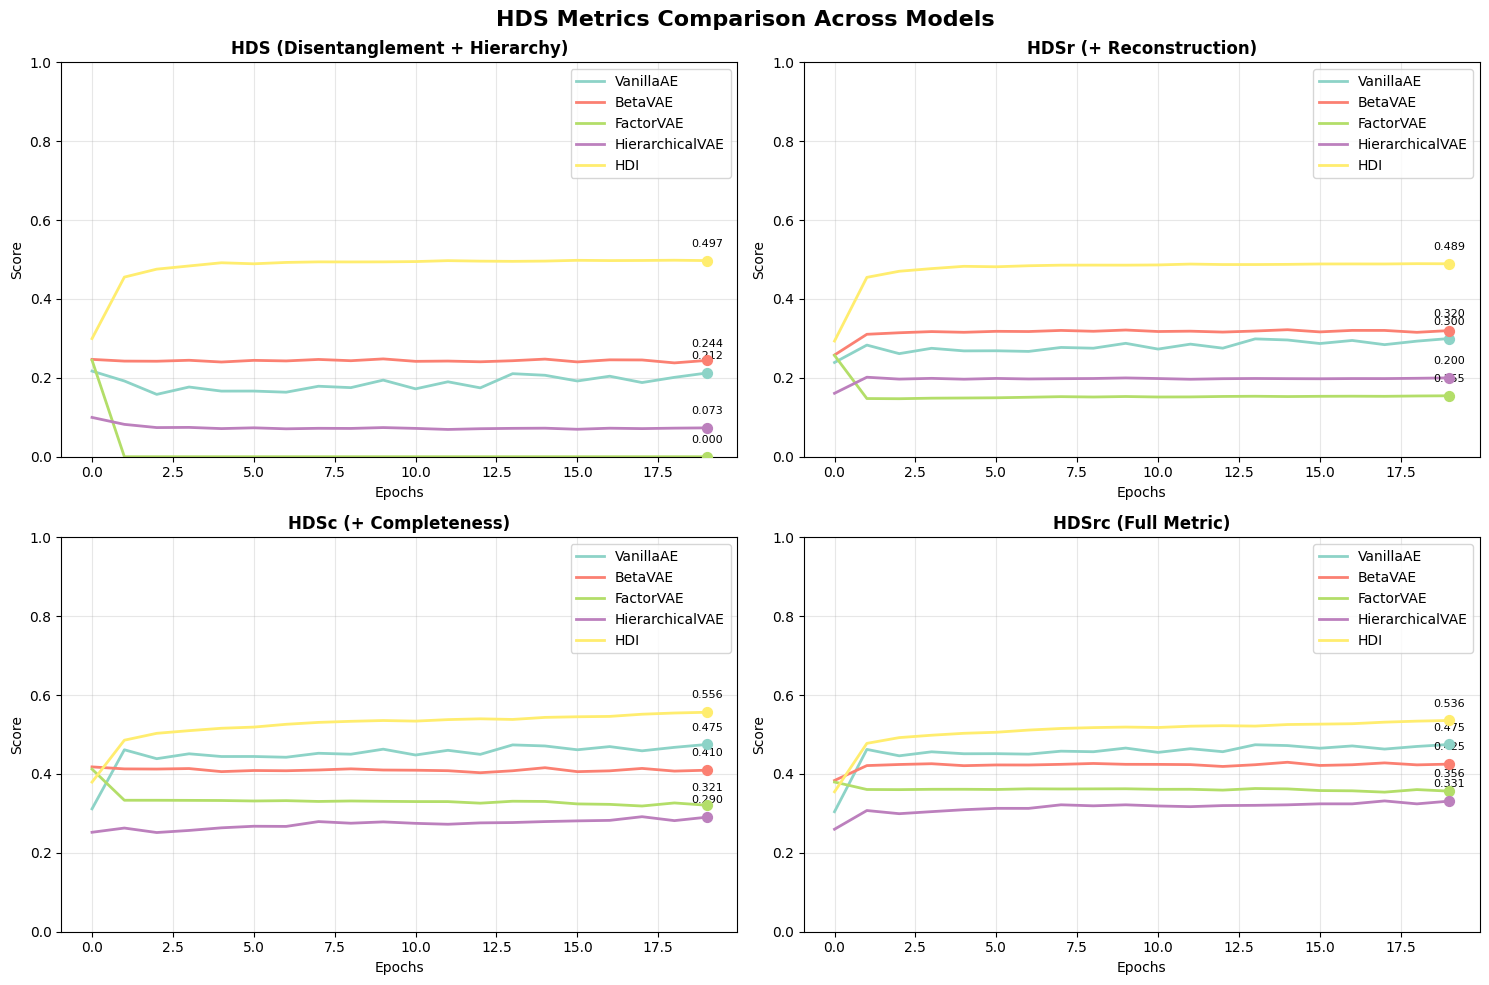

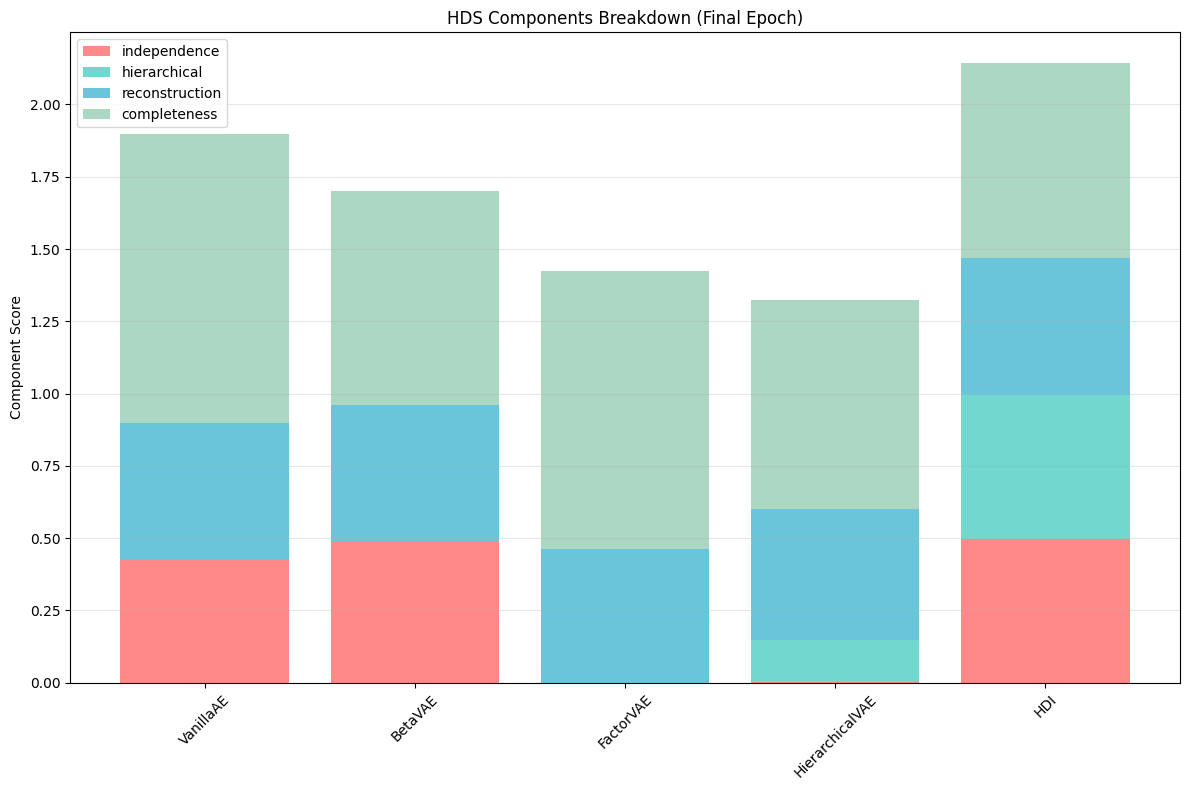

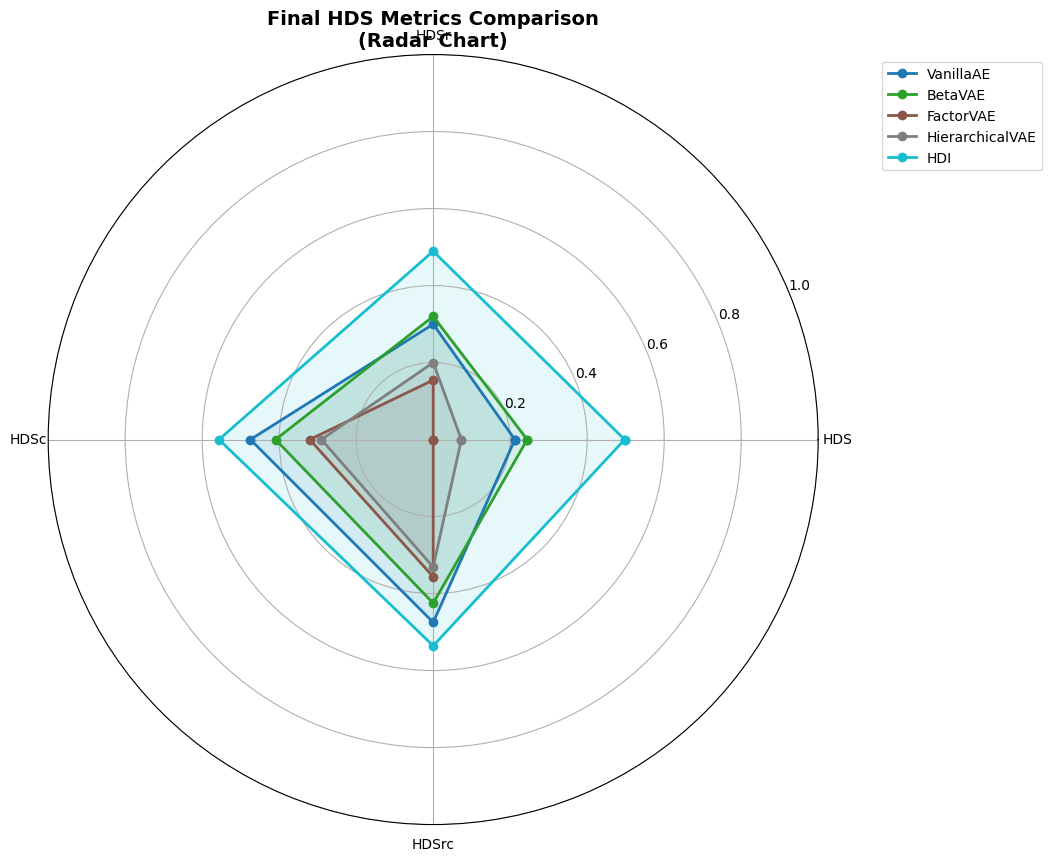


Generating comparison plots...


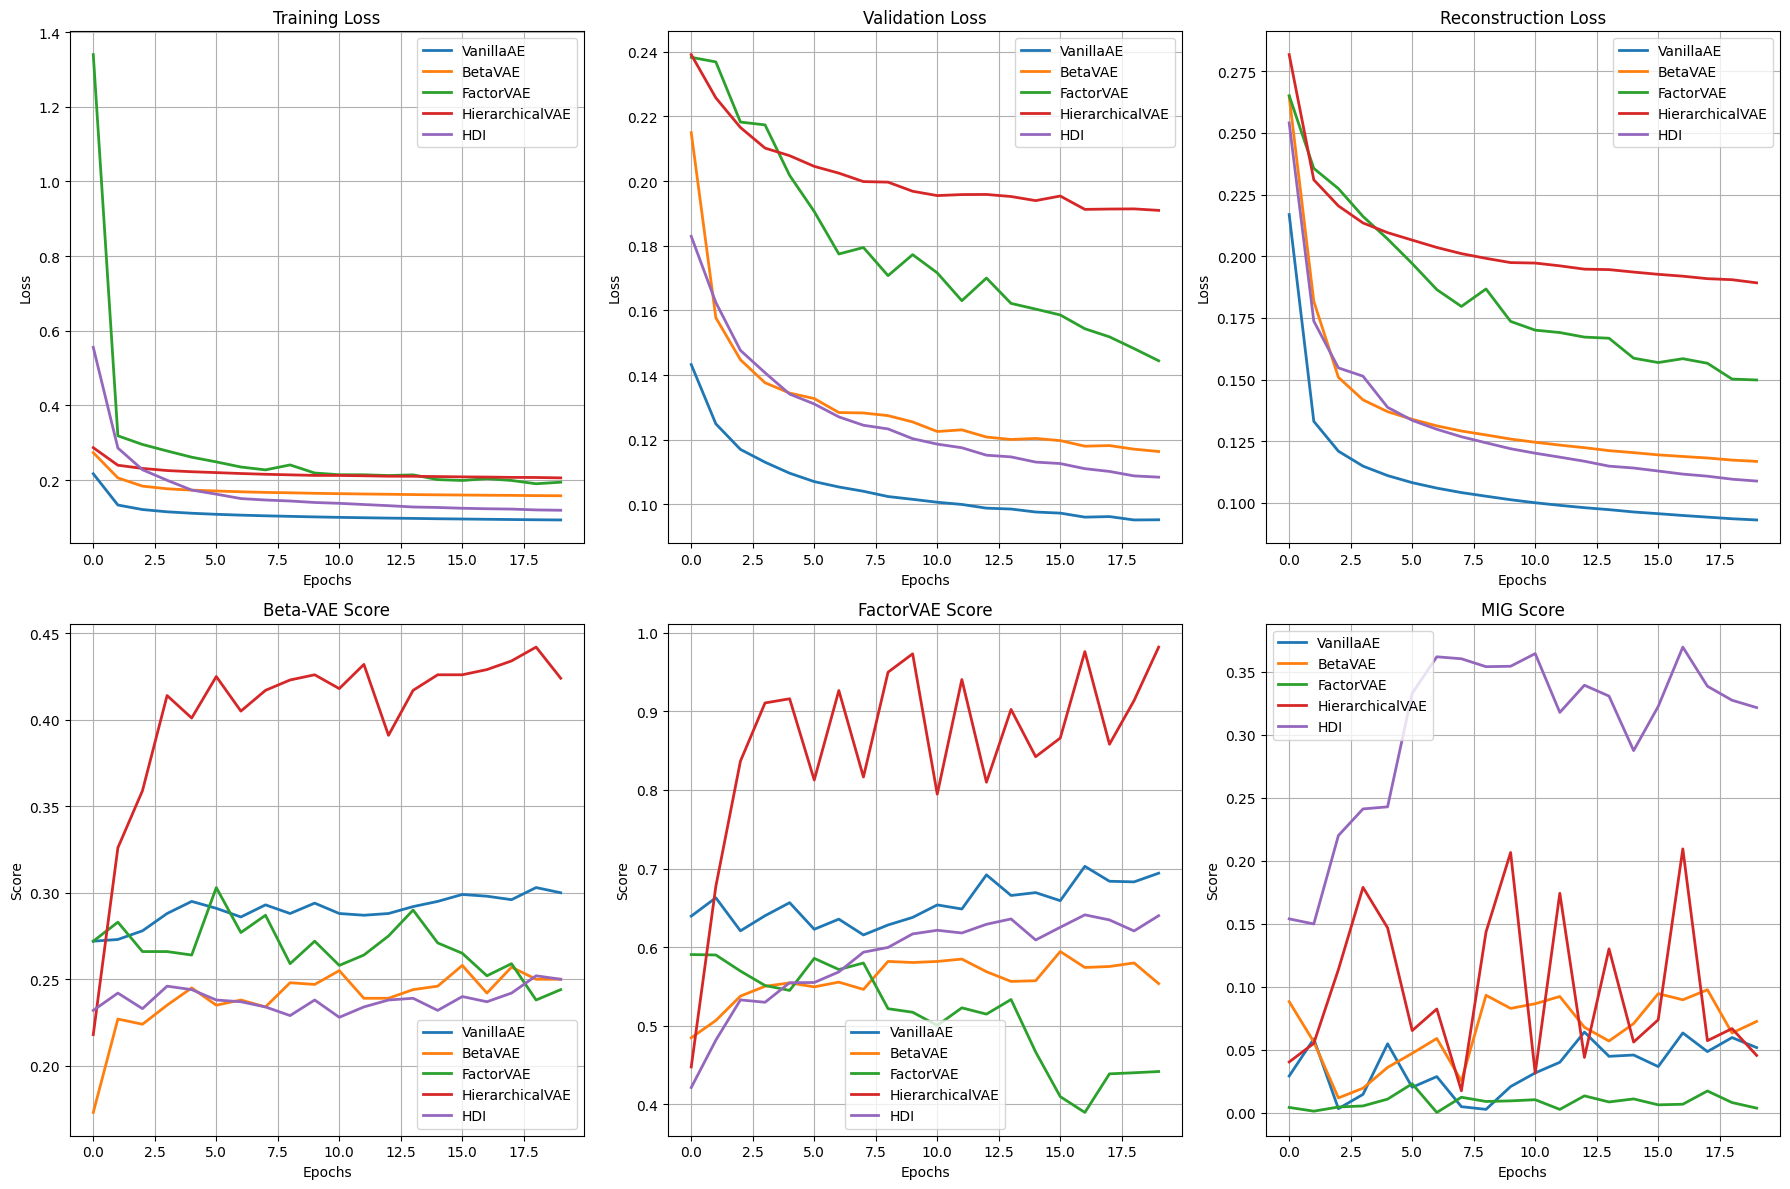

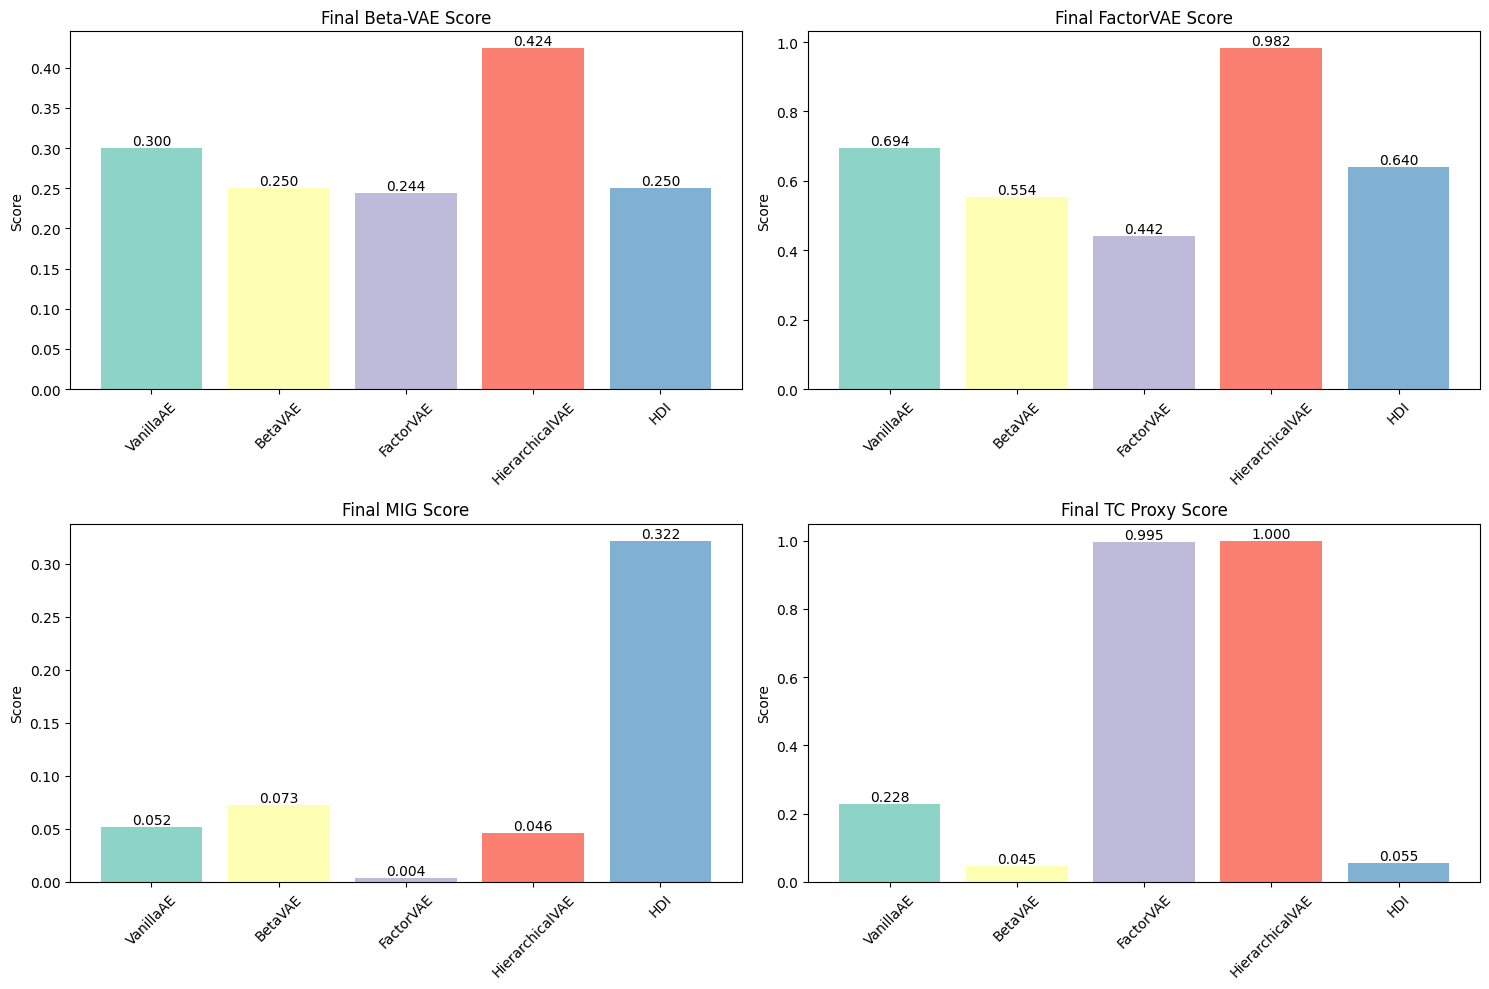

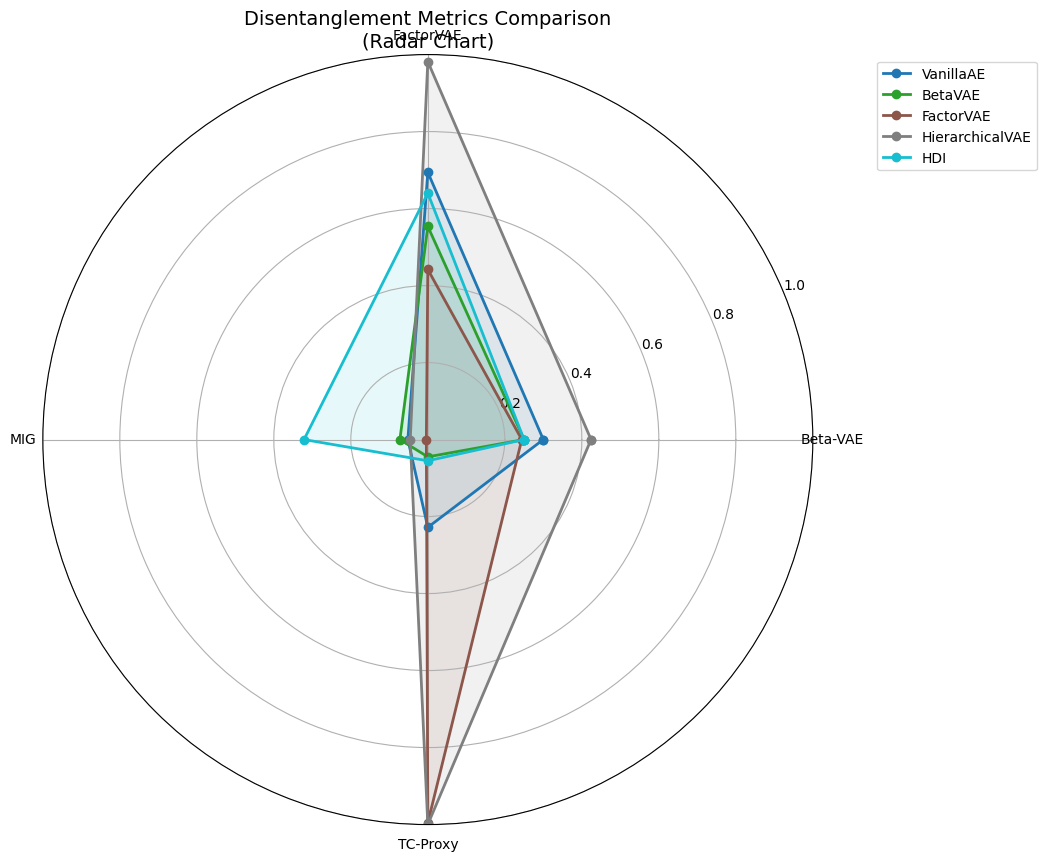

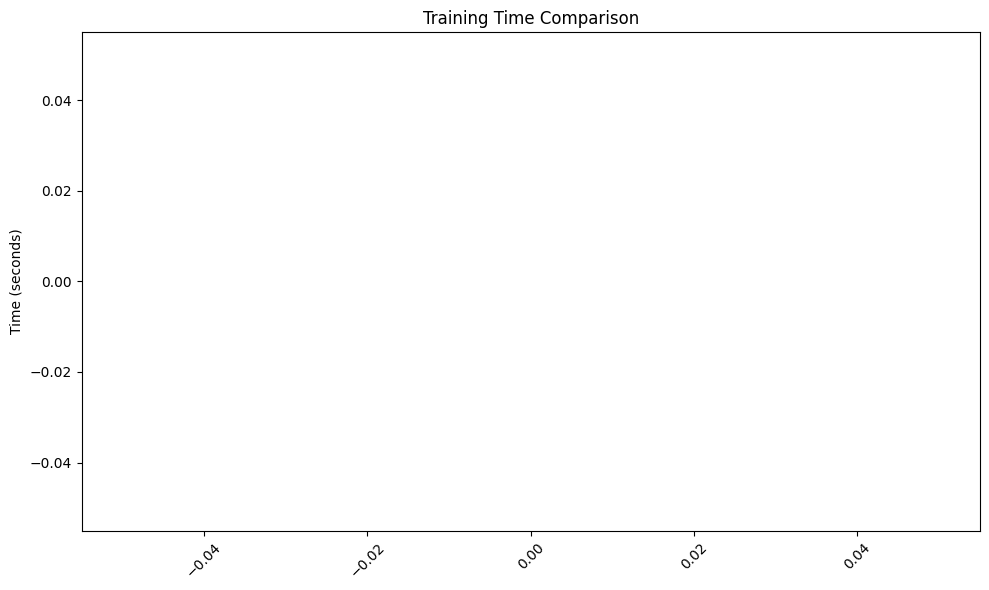


COMPREHENSIVE MODEL COMPARISON RESULTS
Model           Train Time   Beta-VAE    FactorVAE   MIG         TC-Proxy    
--------------------------------------------------------------------------------


KeyError: 'VanillaAE'

In [ ]:
def main_with_hds():
    config = Config()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    comparator = UnifiedModelComparator(config, device)
    comparator.initialize_models()

    num_epochs = 20  # Reduced for testing, increase back to 20 for final run

    print("Starting training with HDS metrics...")
    # comparator = train_with_universal_hds(comparator, train_loader, test_loader, num_epochs)
    comparator = train_with_universal_hds_fixed(comparator, train_loader, test_loader, num_epochs)

    # Comprehensive analysis
    print("\nPerforming comprehensive HDS analysis...")
    comprehensive_hds_analysis(comparator)

    # Traditional metrics comparison
    print("\nGenerating comparison plots...")
    comparator.plot_comparison_results()
    comparator.print_comparison_table()

    # Visualizations
    print("\nGenerating visualizations...")
    plot_sample_reconstructions(comparator, test_loader, device=device)
    plot_latent_space_comparison(comparator, test_loader, device=device)

    return comparator

# Let's run a quick test first
def test_hds_metrics():
    """Test HDS metrics computation without full training"""
    config = Config()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    comparator = UnifiedModelComparator(config, device)
    comparator.initialize_models()

    # Test HDS metrics on one batch
    hds_calculator = UniversalHDIMetrics(device=device)

    for model_name, model in comparator.models.items():
        print(f"Testing HDS metrics for {model_name}...")
        model.eval()

        # Get one batch
        images, labels = next(iter(test_loader))
        images = images.to(device)
        images_flat = images.view(images.size(0), -1)

        with torch.no_grad():
            reconstructed, latent, mu, logvar = model(images_flat)
            reconstruction_loss = nn.MSELoss()(reconstructed, images_flat)

            hds_metrics = hds_calculator.compute_all_metrics(
                (reconstructed, latent),
                reconstruction_loss.item(),
                config.target_correlations,
                config.target_dependence
            )

            print(f"  HDS: {hds_metrics['HDS']:.4f}, HDSr: {hds_metrics['HDSr']:.4f}")

# Run test first
print("Testing HDS metrics computation...")
test_hds_metrics()

# If test passes, run full training
print("\nStarting full training...")
comparator_with_hds = main_with_hds()